In [1]:
# https://colab.research.google.com/drive/1nl7S_pBNg5UgKtU5JzJmwwTsCxFsM2rr?usp=sharing&hl=ru#scrollTo=yRmhWuTT4-pQ

In [2]:
# импорт библиотек
import functools
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt
import seaborn as sns

import h5py
from typing import Tuple
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch import optim

import operator
from functools import reduce
import random
from datetime import datetime

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import copy
from tqdm import tqdm

from sklearn.metrics import mean_absolute_percentage_error

from concurrent.futures import ProcessPoolExecutor

import time
start = time.time()

# Data

In [2]:
# загрузка данных
pq_data = np.load('E:/pq_data_scaled_300.npy') # столбцы p и q
p_x_data = np.load('E:/p_x_data_scaled_300.npy') # все строки с p
q_x_data = np.load('E:/q_x_data_scaled_300.npy') # все строки с q
l_data = np.load('E:/l_data_300.npy')
d_data = np.load('E:/d_data_300.npy')
t_data = np.load('E:/t_data_300.npy')

l_data_min = min(l_data)
l_data_max = max(l_data)

d_data_min = min(d_data)
d_data_max = max(d_data)

t_data_min = min(t_data)
t_data_max = max(t_data)

In [6]:
# размерность
for idx, data in enumerate([pq_data, p_x_data, q_x_data, l_data, d_data, t_data]):
    print(f'Размерность {["pq_data", "p_x_data", "q_x_data", "l_data", "d_data", "t_data"][idx]}: {data.shape}')

Размерность pq_data: (307584, 25, 2)
Размерность p_x_data: (307584, 25, 101)
Размерность q_x_data: (307584, 25, 101)
Размерность l_data: (307584,)
Размерность d_data: (307584,)
Размерность t_data: (307584,)


In [7]:
# минимальные и максимальные значения
data_list = [l_data, d_data, t_data]
names = ["l_data", "d_data", "t_data"]

for idx, data in enumerate(data_list):
    name = names[idx]
    min_value = np.min(data)
    max_value = np.max(data)
    print(f'Min и Max значения для {name}: {min_value}, {max_value}')

Min и Max значения для l_data: 60000, 100000
Min и Max значения для d_data: 0.996, 1.387
Min и Max значения для t_data: 283, 303


In [13]:
# нормализация длины
l_data = (l_data - min(l_data))/(max(l_data) - min(l_data))
l_data[:10]

array([1., 0., 0., 0., 0., 0., 1., 1., 1., 0.])

In [12]:
# нормализация диаметра
d_data = (d_data - min(d_data))/(max(d_data) - min(d_data))
d_data[:10]

array([0.51150895, 0.        , 0.51150895, 0.51150895, 0.        ,
       0.51150895, 0.        , 1.        , 0.        , 0.51150895])

In [11]:
# нормализация температуры
t_data = (t_data - min(t_data))/(max(t_data) - min(t_data))
t_data[:10]

array([0.5, 1. , 0.5, 1. , 0.5, 1. , 0. , 0.5, 0.5, 1. ])

## train/val/test sets

In [14]:
# разбиваем на выборки
np.random.seed(seed = 2023)

all_idx = np.random.permutation(p_x_data.shape[0])
# all_idx = np.random.choice(p_x_data.shape[0], size=p_x_data.shape[0], replace=False)
unique_all_idx = np.unique(all_idx)

# Если длина unique_all_idx совпадает с длиной исходного all_idx, значит, все значения уникальны
if len(unique_all_idx) == len(all_idx):
    print("Все значения уникальны.")
else:
    print("Есть повторяющиеся значения.")
    
train_idx = all_idx[:int(p_x_data.shape[0] * 0.8)]
val_idx = all_idx[int(p_x_data.shape[0] * 0.8) : int(p_x_data.shape[0] * 0.9)]
test_idx = all_idx[int(p_x_data.shape[0] * 0.9) :]

Все значения уникальны.


In [15]:
pd.DataFrame(train_idx, columns=['train_idx']).sort_values(by='train_idx', ascending=True).head(10)

train_idx
2374            0
210169          1
8336            3
23499           5
9512            6
158016          7
237178         11
88071          12
81195          13
237091         14

In [16]:
# проверка, что выборки не пересекаются
(pd.DataFrame(val_idx, columns=['val_idx'])['val_idx'].isin(pd.DataFrame(train_idx, columns=['train_idx'])['train_idx'])).sum()

0

In [18]:
# проверка, что выборки не пересекаются
(pd.DataFrame(test_idx, columns=['test_idx'])['test_idx'].isin(pd.DataFrame(train_idx, columns=['train_idx'])['train_idx'])).sum()

0

In [19]:
# размерность
for idx, data in enumerate([pq_data, p_x_data, q_x_data, l_data, d_data, t_data]):
    print(f'Размерность {["pq_data", "p_x_data", "q_x_data", "l_data", "d_data", "t_data"][idx]}: {data[train_idx].shape}')

Размерность pq_data: (246067, 25, 2)
Размерность p_x_data: (246067, 25, 101)
Размерность q_x_data: (246067, 25, 101)
Размерность l_data: (246067,)
Размерность d_data: (246067,)
Размерность t_data: (246067,)


# NN

In [3]:
################################################################
#  1d Fourier Integral Operator
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, modes: int):
        super(SpectralConv1d, self).__init__()
        """
        Initializes the 1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        Args:
            in_channels (int): input channels to the FNO layer
            out_channels (int): output channels of the FNO layer
            modes (int): number of Fourier modes to multiply, at most floor(N/2) + 1    
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.scale = (1 / (in_channels*out_channels))
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        """
        Complex multiplication of the Fourier modes.
        [batch, in_channels, x], [in_channel, out_channels, x] -> [batch, out_channels, x]
            Args:
                input (torch.Tensor): input tensor of size [batch, in_channels, x]
                weights (torch.Tensor): weight tensor of size [in_channels, out_channels, x]
            Returns:
                torch.Tensor: output tensor with shape [batch, out_channels, x]
        """
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Fourier transformation, multiplication of relevant Fourier modes, backtransformation
        Args:
            x (torch.Tensor): input to forward pass os shape [batch, in_channels, x]
        Returns:
            torch.Tensor: output of size [batch, out_channels, x]
        """
        batchsize = x.shape[0]
        # Fourier transformation
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        # out_ft = torch.zeros(batchsize, self.out_channels, self.modes,  device=x.device, dtype=torch.cfloat)
        # print(self.compl_mul1d(x_ft[:, :, :self.modes], self.weights).shape)
        # print(out_ft[:, :, :self.modes].shape)
        # print("modes", self.modes)
        out_ft[:, :, :self.modes] = self.compl_mul1d(x_ft[:, :, :self.modes], self.weights)
        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

In [4]:
################################################################
#  1d Fourier Network
################################################################
class FNO1d(nn.Module):
    def __init__(self, modes, width, time_l = 5): ######### time_l - число столбцов в pq матрице (3, когда есть еще длина) (4, когда длина и диаметр) (5, когда длина, диаметр и температура)
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: a driving function observed at T timesteps + 1 locations (u(1, x), ..., u(T, x),  x). 
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """
        self.modes = modes
        self.width = width
        self.time_l = time_l
        self.fc0 = nn.Linear(self.time_l, self.width)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 101)

    def forward(self, x):
        # print("in_fc0:", x.shape)
        x = self.fc0(x)
        # print("out_fc0:", x.shape)
        x = x.permute(0, 2, 1)
        # print("in_conv0:", x.shape)
        x1 = self.conv0(x)
        # print("out_conv0:", x1.shape)
        x2 = self.w0(x)
        # print("out_w0:", x2.shape)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

# Train

In [ ]:
################################################################
#  configurations
################################################################

# Experiment Settings
ntrain = pq_data[train_idx].shape[0]  # train samples

In [5]:

device = 'cpu'  #change to cpu of no cuda available
# time_l = 25

#model parameters
modes = 8 # number of Fourier modes to multiply
width = 128 # input and output channels to the FNO layer
batch_size = 32
# num_epochs = 120 #set to one so faster computation, in principle 20 is best # задается ниже

learning_rate = 0.005 ################################################################################ was 0.05
lr_decay = 0.1 
num_workers = 0

In [23]:
# print the number of parameters
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

# model
model = FNO1d(modes, width).to(device)
print('Number of paramters: {}'.format(count_params(model)))

Number of paramters: 1144933


In [24]:
# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0, 20, 40, 60, 80], gamma=lr_decay)

In [25]:
criterion = torch.nn.MSELoss(reduction="none")

In [26]:
def bootstrap(x: torch.Tensor, Nboot: int=64, binsize: int=1) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Bootstrapping mean or median to obtain standard deviation.
    Args:
        x (torch.Tensor): input tensor, which contains all the results on the different trajectories of the set at hand
        Nboot (int): number of bootstrapping steps, 64 is quite common default value
        binsize (int):
    Returns:
        torch.Tensor: bootstrapped mean/median of input
        torch.Tensor: bootstrapped variance of input
    """
    boots = []
    x = x.reshape(-1, binsize, *x.shape[1:])
    for i in range(Nboot):
        boots.append(torch.mean(x[torch.randint(len(x), (len(x),))], axis=(0, 1)))
    return torch.tensor(boots).mean(), torch.tensor(boots).std()


def training_loop(loader_pq, loader_p, model, optimizer, criterion, device, batch_size):
  """
  Training loop.
  Loop is over the mini-batches and for every batch we pick a random timestep.
  This is done iteratively for the number of timesteps in one training sample.
  One average, we therefore start at every starting point in every trajectory during one episode.
  Args:
      model (torch.nn.Module): neural network model
      optimizer (torch.optim): chosen optimizer
      loader (DataLoader): train/valid/test dataloader
      criterion (torch.nn.modules.loss): loss criterion
      device: device (cpu/gpu)
  """
  losses = []
  for (datapoints_pq, datapoints_p) in zip(loader_pq, loader_p):
      optimizer.zero_grad()
      #xj_list = torch.tensor(np.linspace(0, 99, 99), dtype=torch.float)
      #data, labels = create_data(datapoints_pq, datapoints_p, xj_list)
      data, labels = datapoints_pq.to(device), datapoints_p.to(device)

      # Change [batch, time, space] -> [batch, space, time]
      # data = data.permute(0, 2, 1) # ?????????????
      #forward pass
      # print(data.shape)
      pred = model(data)
      # print(pred.shape)
      # print(labels.shape)
      loss = criterion(pred, labels)
      #loss = criterion(pred.permute(0, 2, 1), labels) # ???????????
      #loss = criterion(pred, labels)
      loss = loss.sum()
      loss.backward()
      losses.append(loss.detach() / batch_size)
      optimizer.step()
  losses = torch.stack(losses)
  return losses

def test(loader_pq, loader_p, model, criterion, device, batch_size):
    """
    Test routine.
    Both step wise losses and enrolled forward losses are computed.
    Args:
        model (torch.nn.Module): neural network model
        loader (DataLoader): train/valid/test dataloader
        criterion (torch.nn.modules.loss): loss criterion
        device: device (cpu/gpu)
    Returns:
        (torch.Tensor, torch.Tensor, torch.Tensor, torch. Tensor): mean and normalized mean errors
        of full trajectory unrolling
    """
    losses = []
    for (datapoints_pq, datapoints_p) in zip(loader_pq, loader_p):
        with torch.no_grad():
            # the first time steps are used for data augmentation according to time translate
            # we ignore these timesteps in the testing
            data, labels = datapoints_pq.to(device), datapoints_p.to(device)
            print(labels.shape)
            pred = model(data)
            loss = criterion(pred, labels)
            #loss = criterion(pred.permute(0, 2, 1), labels) # ???????????
            loss = loss.sum()
            losses.append(loss.detach().numpy() / batch_size)

    return np.array(losses)

def plot_losses(train_loss, val_loss):
    x = np.linspace(0, len(train_loss), len(train_loss))
    plt.plot(x, train_loss, label = "Loss train")
    plt.plot(x, val_loss, label = "Loss validation")
    plt.legend()
    plt.show()

# Add length

In [27]:
pq_data_len = []
for i in range(l_data.shape[0]):
    # print(np.repeat(l_data[i], pq_data.shape[1]))
    pq_data_len.append(np.stack((pq_data[i][:, 0], pq_data[i][:, 1], np.repeat(l_data[i], pq_data.shape[1])), axis = 1))

pq_data_len = np.array(pq_data_len)
pq_data_len.shape

(307584, 25, 3)

In [28]:
pq_data = pq_data_len.copy()
pq_data.shape

(307584, 25, 3)

# Add diameter

In [29]:
pq_data_len = []
for i in range(d_data.shape[0]):
    pq_data_len.append(np.stack((pq_data[i][:, 0], pq_data[i][:, 1], pq_data[i][:, 2], np.repeat(d_data[i], pq_data.shape[1])), axis = 1))

pq_data_len = np.array(pq_data_len)
pq_data_len.shape

(307584, 25, 4)

In [30]:
pq_data = pq_data_len.copy()
pq_data.shape

(307584, 25, 4)

# Add temperature

In [31]:
pq_data_len = []
for i in range(t_data.shape[0]):
    pq_data_len.append(np.stack((pq_data[i][:, 0], pq_data[i][:, 1], pq_data[i][:, 2], pq_data[i][:, 3], np.repeat(t_data[i], pq_data.shape[1])), axis = 1))

pq_data_len = np.array(pq_data_len)
pq_data_len.shape

(307584, 25, 5)

In [32]:
pq_data = pq_data_len.copy()
pq_data.shape

(307584, 25, 5)

# Train the PDE solver

In [41]:
min_val_loss = 10e30
test_loss, ntest_loss = 10e30, 10e30
test_loss_std, ntest_loss_std = 0., 0.

# Log file and save path for model
dateTimeObj = datetime.now()
timestring = f'{dateTimeObj.date().month}{dateTimeObj.date().day}{dateTimeObj.time().hour}{dateTimeObj.time().minute}'

# pq_data_loader = DataLoader(torch.Tensor(pq_data[train_idx]), batch_size=batch_size, shuffle=False)
pq_data_loader = DataLoader(torch.Tensor(pq_data[train_idx]), batch_size=batch_size, shuffle=False) ###### shuffle
p_x_data_loader = DataLoader(torch.Tensor(p_x_data[train_idx]), batch_size=batch_size, shuffle=False) ###### shuffle

pq_data_loader_val = DataLoader(torch.Tensor(pq_data[val_idx]), batch_size=batch_size, shuffle=False) ###### shuffle
p_x_data_loader_val = DataLoader(torch.Tensor(p_x_data[val_idx]), batch_size=batch_size, shuffle=False) ###### shuffle

save_path = f'FNO1d_truba_{timestring}_L_D_T_p.pt'

print(pq_data_loader.dataset.shape)

torch.Size([246067, 25, 5])


In [42]:
p_x_data_loader.dataset[0].shape

torch.Size([25, 101])

In [34]:
#МОДЕЛЬ ОБУЧЕНА, ЕЕ МОЖНО ПОДГРУЗИТЬ НИЖЕ В Test, ЗАНОВО ОБУЧАТЬ НЕ НУЖНО (ЗАКОММЕНТИРОВАНО)

In [35]:
# from time import time
# # Таймер
# t0 = time()

# train_losses = []
# val_losses = []
# num_epochs = 5
# # num_epochs = 10 ################################################################################################################################


# for epoch in range(num_epochs):
#     t1 = time()
#     print(f"Epoch {epoch}")
#     ################################################################
#     # train model
#     ################################################################
#     model.train()
#     #run every epoch (twice) as often as we have number of time steps in one trajectory 
#     losses = training_loop(pq_data_loader,
#                            p_x_data_loader,
#                            model, optimizer, criterion, device, batch_size)

#     print(f'Training Loss: {torch.mean(losses)}')
          
#     ################################################################
#     # evaluate model on validation data
#     ################################################################

#     # Test the losses (full trajectory)
#     val_loss = np.mean(test(pq_data_loader_val, p_x_data_loader_val, model, criterion, device, batch_size))
#     print("Evaluation on validation dataset:", val_loss)

#     train_losses.append(torch.mean(losses))
#     val_losses.append(val_loss)
#     if(val_loss < min_val_loss):
#         # Save model
#         torch.save(model.state_dict(), save_path) 
#         min_val_loss = val_loss

#     scheduler.step()
#     t2 = time()
#     time_fno_epoh = t2-t1
#     print('\nВремя обучения (эпоха): {:.3f} секунд'.format(time_fno_epoh))
    
# time_fno_tr = time()-t0
# # Выводится время вычисления
# print('\nВремя обучения составляет: {:.3f} секунд'.format(time_fno_tr))

In [36]:
# plot_losses(train_losses, val_losses)

In [37]:
# plot_losses(train_losses, val_losses)

In [38]:
# plot_losses(train_losses, val_losses)

In [39]:
# plot_losses(np.log(train_losses), np.log(val_losses))

In [40]:
# plot_losses(np.log(train_losses), np.log(val_losses))

In [41]:
# plot_losses(np.log(train_losses), np.log(val_losses))

In [42]:
# len(train_losses)

In [43]:
# torch.save(model.state_dict(), save_path) 

# Test

In [45]:
p_x_data_test = copy.deepcopy(p_x_data[test_idx])

In [46]:
pq_data_test = copy.deepcopy(pq_data[test_idx])

In [47]:
# поиск минимальных значений в конце трубы,
# формирование из них списка
min_array = []

for i in tqdm(range(len(p_x_data_test))):
    min_array.append(min(p_x_data_test[i][:, 100]))

100%|██████████| 30759/30759 [00:00<00:00, 274569.08it/s]


In [48]:
# количество сценариев с давлением в конце трубы менее 3 МПа
(pd.Series(min_array) < 0.33).sum()

2116

In [49]:
# отбираем сценариии с давлением в конце трубы не менее 3 МПа
ind_3 = np.array(pd.Series(min_array)[(pd.Series(min_array) > 0.33)].index)

In [50]:
ind_3.shape

(28643,)

In [51]:
# тестовые массивы
pq_data_loader_test = DataLoader(torch.Tensor(pq_data_test[ind_3]), batch_size=None, shuffle=False)
p_x_data_loader_test = DataLoader(torch.Tensor(p_x_data_test[ind_3]), batch_size=None, shuffle=False)

In [6]:
# загружаем обученную модель
modelpath = 'FNO1d_truba_1222126_L_D_T_p_cuda.pt' #if you want, replace with the model you just have trained!
model = FNO1d(modes, width).to(device)
model.load_state_dict(torch.load(modelpath,map_location = torch.device(device))) #if you want replace with the model you trained! 
model.eval()

FNO1d(
  (fc0): Linear(in_features=5, out_features=128, bias=True)
  (conv0): SpectralConv1d()
  (conv1): SpectralConv1d()
  (conv2): SpectralConv1d()
  (conv3): SpectralConv1d()
  (w0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  (w1): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  (w2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  (w3): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=101, bias=True)
)

In [53]:
# приведение значений к исходному масштабу
def inverse_min_max_scaling(min, max, x_scaled):
    return x_scaled * (max - min) + min

In [54]:
# минимальные значения по давлению и расходу по всем сценариям
min_value_p = 0.7826574758735468
max_value_p = 7.5
min_value_q = 25.45561240527438
max_value_q = 153.415204110947

torch.Size([1, 25, 101])
torch.Size([25, 101])
torch.Size([1, 25, 101])
torch.Size([25, 101])
torch.Size([1, 25, 101])
torch.Size([25, 101])


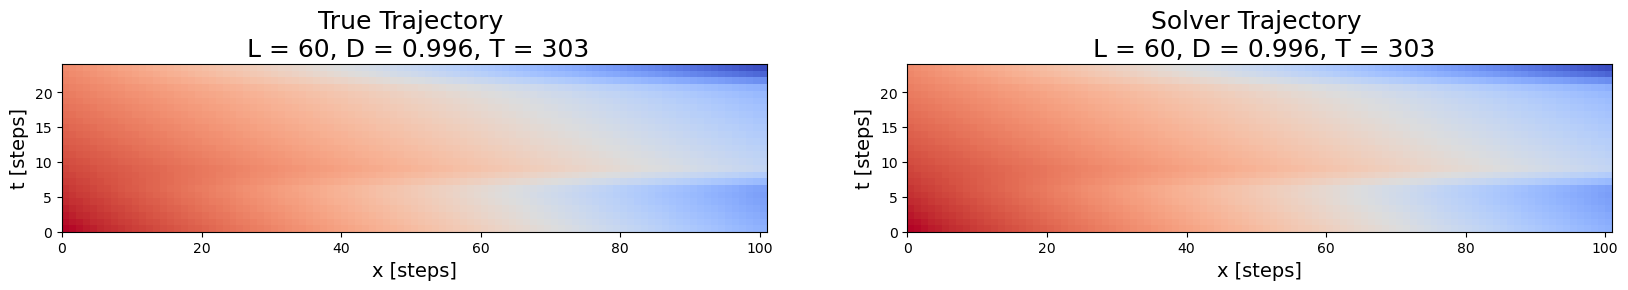

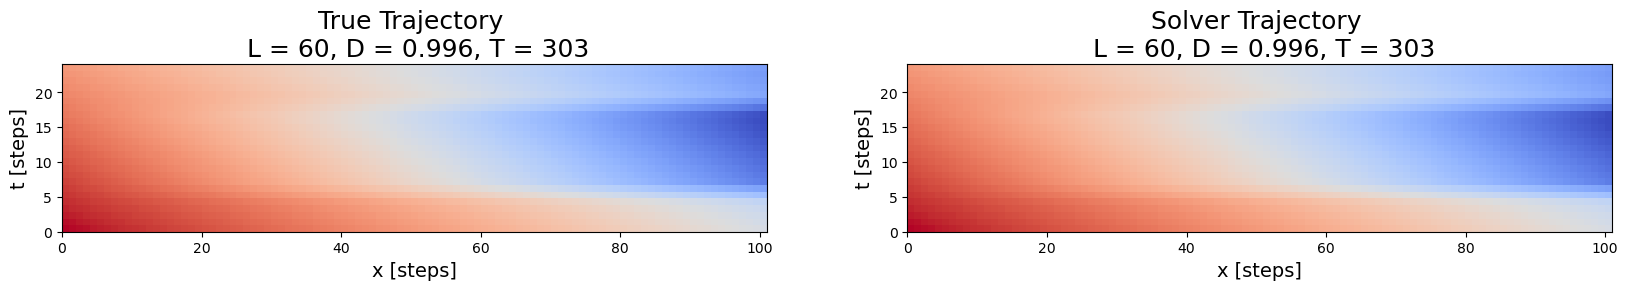

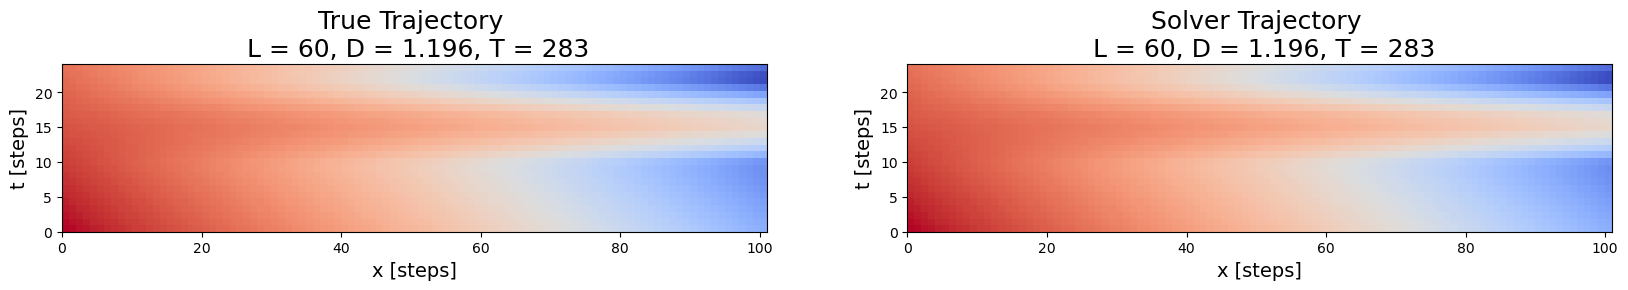

In [56]:
# построение трех случайных 2D отображений изменения давления вдоль трубы
random_indices = random.sample(range(len(p_x_data_loader_test)), 3)

for test_val in random_indices:
    with torch.no_grad():
        x_data = pq_data_loader_test.dataset[test_val][None, :, :]
        pred = model(x_data)
        print(pred.shape)
        y_data = p_x_data_loader_test.dataset[test_val]
        print(y_data.shape)
        
        
        # Применение обратного преобразования Min-Max Scaling к данным
    
    l_original = inverse_min_max_scaling(l_data_min, l_data_max, x_data[:, 1, 2]) / 1000
    d_original = inverse_min_max_scaling(d_data_min, d_data_max, x_data[:, 1, 3])
    t_original = inverse_min_max_scaling(t_data_min, t_data_max, x_data[:, 1, 4])
        
    # Построение графиков истинных и предсказанных значений
    L=101
    T=24
    f, axarr = plt.subplots(1,2, figsize=(20,20))
    axarr[0].set_title(f'True Trajectory \n L = {int(l_original)}, D = {round(float(d_original),3)}, T = {int(t_original)}', fontsize=18)
    axarr[1].set_title(f'Solver Trajectory \n L = {int(l_original)}, D = {round(float(d_original),3)}, T = {int(t_original)}', fontsize=18)
    axarr[0].imshow(y_data, extent=[0,L,0,T], cmap='coolwarm')
    axarr[1].imshow(pred[0, :, :], extent=[0,L,0,T], cmap='coolwarm')
    axarr[0].set_xlabel('x [steps]', fontsize=14)
    axarr[0].set_ylabel('t [steps]', fontsize=14)
    axarr[1].set_xlabel('x [steps]', fontsize=14)
    axarr[1].set_ylabel('t [steps]', fontsize=14)

torch.Size([1, 25, 101])
torch.Size([25, 101])


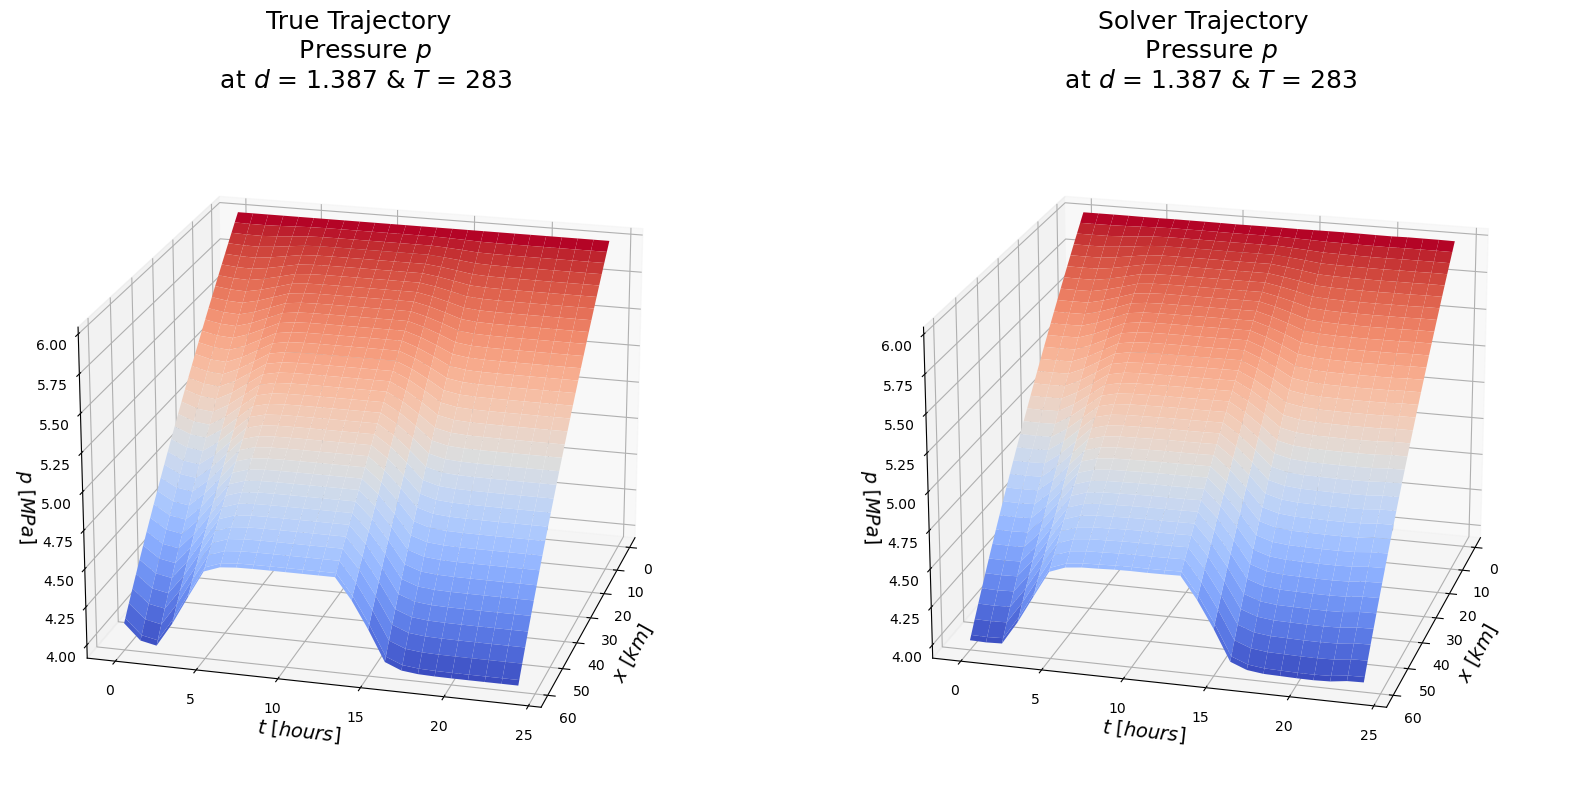

torch.Size([1, 25, 101])
torch.Size([25, 101])


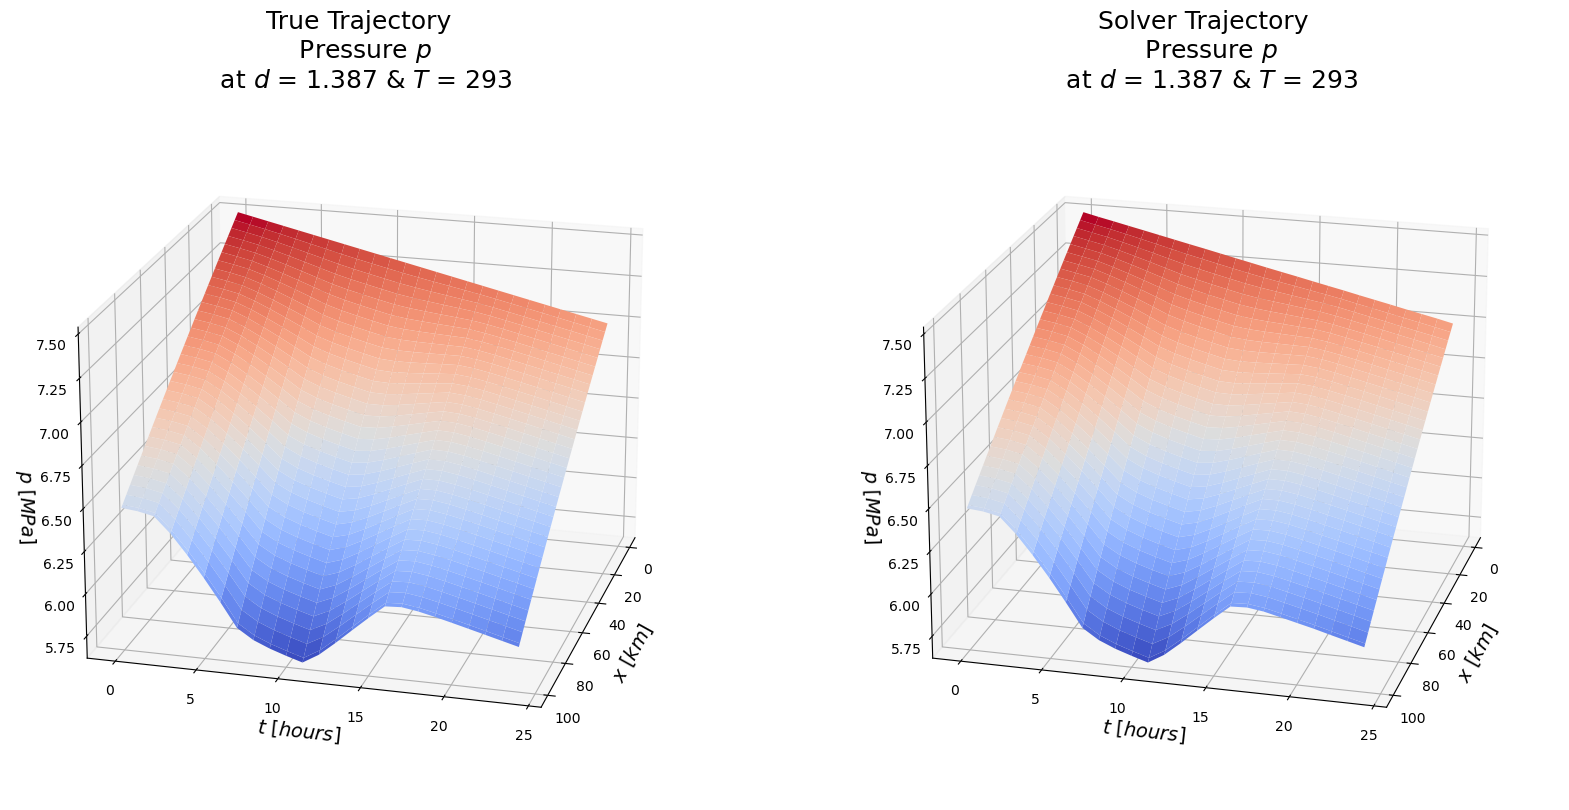

torch.Size([1, 25, 101])
torch.Size([25, 101])


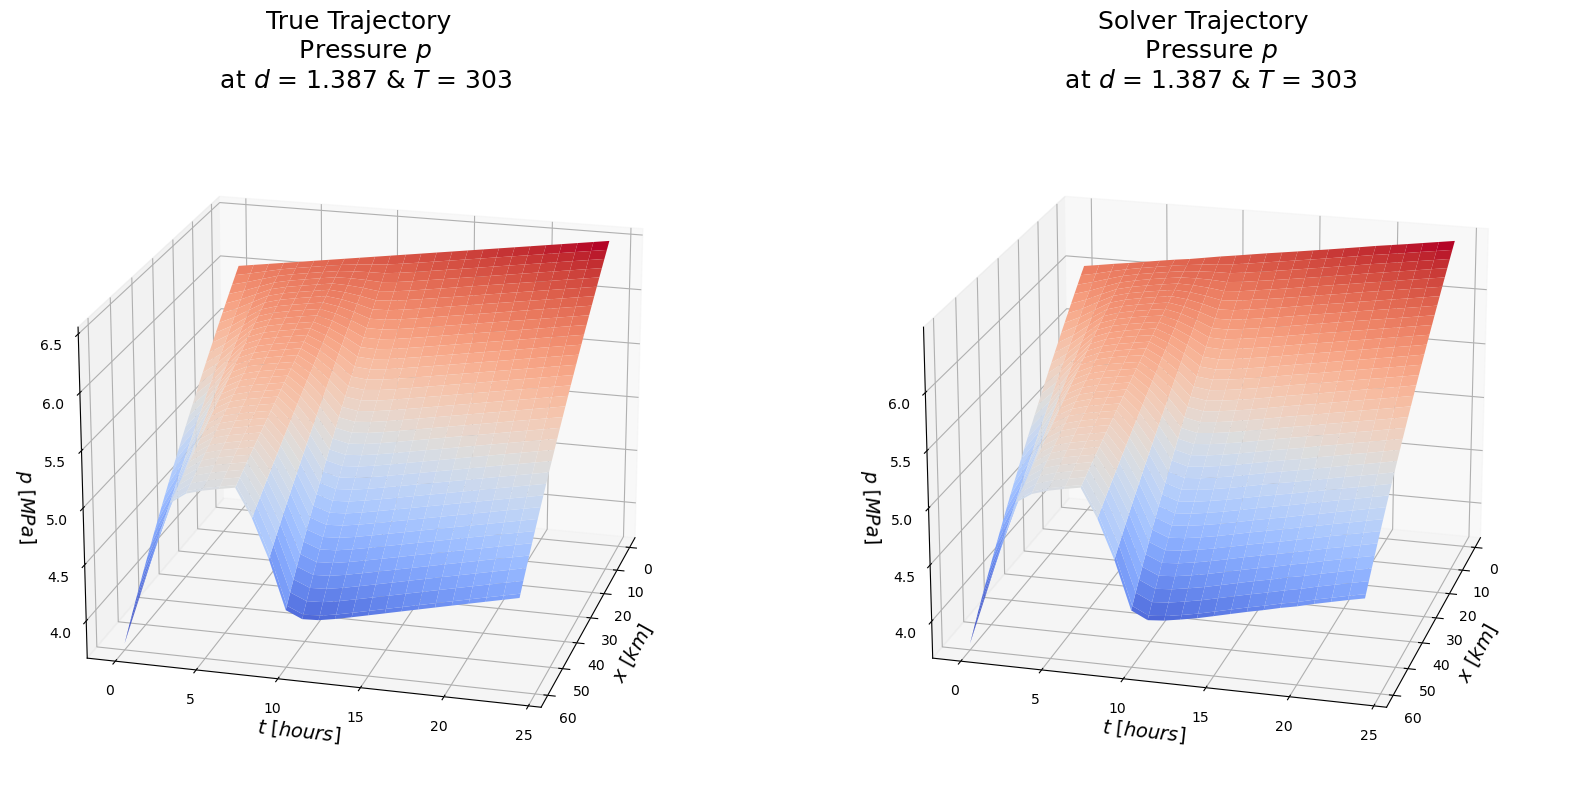

In [57]:
# построение трех случайных 3D отображений изменения давления вдоль трубы

random_indices = random.sample(range(len(p_x_data_loader_test)), 3)

for test_val in random_indices:
    with torch.no_grad():
        x_data = pq_data_loader_test.dataset[test_val][None, :, :]
        pred = model(x_data)
        print(pred.shape)
        y_data = p_x_data_loader_test.dataset[test_val]
        print(y_data.shape)
    
    # Применение обратного преобразования Min-Max Scaling к данным
    y_data_original = inverse_min_max_scaling(min_value_p, max_value_p, y_data)
    pred_original = inverse_min_max_scaling(min_value_p, max_value_p, pred[0, :, :])
    l_original = inverse_min_max_scaling(l_data_min, l_data_max, x_data[:, 1, 2]) / 1000
    d_original = inverse_min_max_scaling(d_data_min, d_data_max, x_data[:, 1, 3])
    t_original = inverse_min_max_scaling(t_data_min, t_data_max, x_data[:, 1, 4])
        
    # Построение графиков истинных и предсказанных значений
    L = 101
    T = 25

    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    ax1.set_title(f'True Trajectory \n Pressure $p$ \n at $d$ = {round(float(d_original),3)} & $T$ = {int(t_original)}', fontsize=18)
    ax2.set_title(f'Solver Trajectory \n Pressure $p$ \n at $d$ = {round(float(d_original),3)} & $T$ = {int(t_original)}', fontsize=18)

    # Истинная траектория
    x_data_mesh, t_data_mesh = np.meshgrid(np.linspace(0, l_original, L), np.linspace(0, 24, T))
    ax1.plot_surface(x_data_mesh, t_data_mesh, y_data_original, cmap='coolwarm')

    # Предсказанная траектория
    ax2.plot_surface(x_data_mesh, t_data_mesh, pred_original, cmap='coolwarm')

    ax1.set_xlabel('$x$ [$km$]', fontsize=14)
    ax1.set_ylabel('$t$ [$hours$]', fontsize=14)
    ax1.set_zlabel('$p$ [$MPa$]', fontsize=14)
    ax1.view_init(elev=20, azim=15)

    ax2.set_xlabel('$x$ [$km$]', fontsize=14)
    ax2.set_ylabel('$t$ [$hours$]', fontsize=14)
    ax2.set_zlabel('$p$ [$MPa$]', fontsize=14)
    ax2.view_init(elev=20, azim=15)

    plt.show();

In [59]:
# функция вычисления MAPE
def calculate_metric(y_true, y_pred):
    mape = mean_absolute_percentage_error(np.ravel(y_true), np.ravel(y_pred))
    return mape

In [60]:
# приведение значений к исходному масштабу
def rescale_back(x, min = 0.7826574758735468, max = 7.5): # 
    return x*(max - min) + min

In [61]:
# Определение метрик и абсолютной разницы в давлении между истинными и предсказанными значениями для всех временных слоев
metrics = []
metrics_max = []
ls = []
ds = []
ts = []
diffs = []



for test_val in range(0, len(ind_3)):
    with torch.no_grad():
        x_data = pq_data_loader_test.dataset[test_val][None, :, :]
        pred = model(x_data)
        y_data = p_x_data_loader_test.dataset[test_val]
        y_true = inverse_min_max_scaling(min_value_p, max_value_p, y_data.numpy())
        y_pred = inverse_min_max_scaling(min_value_p, max_value_p, pred.numpy()[0])
        cur_metric = calculate_metric(y_true, y_pred)
        print(cur_metric)
        metrics.append(cur_metric)
        metrics_max.append(max(abs((np.ravel(y_pred) - np.ravel(y_true))/np.ravel(y_true))))
        ls.append(inverse_min_max_scaling(l_data_min, l_data_max, float(pq_data_loader_test.dataset[test_val][None, :, :][-1][:, -3][0])))
        ds.append(inverse_min_max_scaling(d_data_min, d_data_max, float(pq_data_loader_test.dataset[test_val][None, :, :][-1][:, -2][0])))
        ts.append(inverse_min_max_scaling(t_data_min, t_data_max, float(pq_data_loader_test.dataset[test_val][None, :, :][-1][:, -1][0])))
        diffs.append(abs(y_pred - y_true))
        
end = time.time()
print(end - start)

0.00035829982
0.0008065037
0.00015411
0.0002298113
6.1757506e-05
9.3947136e-05
0.0006283255
0.00017522632
8.852935e-05
8.6366235e-05
0.00025029716
0.00090009643
0.00016205308
0.00010018625
0.00010576351
0.0001518518
0.0012195917
0.0012837128
9.1267095e-05
8.733814e-05
5.466087e-05
0.00013521603
7.867999e-05
0.00014874343
0.00026686856
0.00010204391
0.00010918084
0.00026459928
0.002154615
0.00010424031
0.00019542538
0.00016259556
0.001288546
0.00046028322
9.182144e-05
0.00011561507
0.00020055237
0.00010233763
0.00015441529
0.00028447912
0.00016278568
0.0005666176
0.0006654921
0.0008449711
0.0001560348
8.297656e-05
0.00034985086
0.0001586051
8.82571e-05
6.741403e-05
0.004125295
0.00043127392
0.00036864216
7.340363e-05
0.00027863355
6.0534665e-05
0.00011027948
0.0004000883
0.00017476016
0.0004848112
0.00016891892
0.00020286744
8.5548185e-05
0.00014458453
0.0002165711
0.00011931856
0.00010060828
0.00013324336
0.00011968636
0.00082081655
0.0005261667
0.00024794336
0.000107176136
0.002060491

In [62]:
# Определение метрик и абсолютной разницы в давлении между истинными и предсказанными значениями с учетом исключения первых двух временных слоев (начальные условия)
metrics_0 = []
metrics_max_0 = []
ls_0 = []
ds_0 = []
ts_0 = []
diffs_0 = []

start_0 = time.time()

for test_val_0 in range(0, len(ind_3)):
    with torch.no_grad():
        x_data_0 = pq_data_loader_test.dataset[test_val_0][None, :, :]
        pred_0 = model(x_data_0)
        y_data_0 = p_x_data_loader_test.dataset[test_val_0][2:]
        y_true_0 = rescale_back(y_data_0.numpy())
        y_pred_0 = rescale_back(pred_0[:, 2:, :].numpy()[0])
        cur_metric_0 = calculate_metric(y_true_0, y_pred_0)
        print(cur_metric_0)
        metrics_0.append(cur_metric_0)
        metrics_max_0.append(max(abs((np.ravel(y_pred_0) - np.ravel(y_true_0))/np.ravel(y_true_0))))
        ls_0.append(float(pq_data_loader_test.dataset[test_val_0][None, 1:, :][-1][:, -3][0]))
        ds_0.append(float(pq_data_loader_test.dataset[test_val_0][None, 1:, :][-1][:, -2][0]))
        ts_0.append(float(pq_data_loader_test.dataset[test_val_0][None, 1:, :][-1][:, -1][0]))
        diffs_0.append(abs(y_pred_0 - y_true_0))
        
end_0 = time.time()
print(end_0 - start_0)

0.0002245502
0.0004389717
0.00016065982
8.83307e-05
6.082238e-05
8.6126376e-05
0.0006489845
0.00016378523
8.5089094e-05
9.04996e-05
0.0001648024
0.0007136574
0.00012711834
9.639103e-05
0.00010997255
0.00013770832
0.00074241834
0.0007672823
8.915224e-05
8.394743e-05
5.349303e-05
0.00013502581
7.4265256e-05
0.0001382483
0.0002815234
9.751408e-05
0.0001082655
0.00025338033
0.0011762164
0.00010544948
0.00019066058
0.0001666746
0.00066408527
0.0004823879
8.75087e-05
0.000115866635
0.00011658122
9.4262745e-05
0.00013531896
0.00028626123
0.00015457306
0.0003158341
0.0003856337
0.00051459967
0.0001599499
8.151085e-05
0.00033818797
0.00016214303
8.516444e-05
6.731842e-05
0.0032617266
0.00030074804
0.00038416937
7.10803e-05
0.00029043705
5.9055234e-05
0.00010691775
0.00037359292
0.00017932025
0.0002550523
0.00016633932
0.0001894984
8.119707e-05
0.00014427715
0.00010646321
0.00012341035
9.809725e-05
0.00013236748
0.0001099951
0.00054242
0.0003671221
0.00021948057
0.00010379261
0.0011351802
0.0001

In [63]:
# Определение метрик и абсолютной разницы в давлении между истинными и предсказанными значениями с учетом дополнительного исключения последних четырех временных слоев (физические ограничения для давления и потребления для трубы 1020)
metrics_0_0 = []
metrics_max_0_0 = []
ls_0_0 = []
ds_0_0 = []
ts_0_0 = []
diffs_0_0 = []

start_0_0 = time.time()

for test_val_0_0 in range(0, len(ind_3)):
    with torch.no_grad():
        x_data_0_0 = pq_data_loader_test.dataset[test_val_0_0][None, :, :]
        pred_0_0 = model(x_data_0_0)
        y_data_0_0 = p_x_data_loader_test.dataset[test_val_0_0][2:-4]
        y_true_0_0 = rescale_back(y_data_0_0.numpy())
        y_pred_0_0 = rescale_back(pred_0_0[:, 2:-4, :].numpy()[0])
        cur_metric_0_0 = calculate_metric(y_true_0_0, y_pred_0_0)
        print(cur_metric_0_0)
        metrics_0_0.append(cur_metric_0_0)
        metrics_max_0_0.append(max(abs((np.ravel(y_pred_0_0) - np.ravel(y_true_0_0))/np.ravel(y_true_0_0))))
        ls_0_0.append(float(pq_data_loader_test.dataset[test_val_0_0][None, 1:, :][-1][:, -3][0]))
        ds_0_0.append(float(pq_data_loader_test.dataset[test_val_0_0][None, 1:, :][-1][:, -2][0]))
        ts_0_0.append(float(pq_data_loader_test.dataset[test_val_0_0][None, 1:, :][-1][:, -1][0]))
        diffs_0_0.append(abs(y_pred_0_0 - y_true_0_0))
        
end_0_0 = time.time()
print(end_0_0 - start_0_0)

0.00023427034
0.00021106275
0.00016427193
8.425836e-05
5.6318837e-05
8.635735e-05
0.0006622011
0.00016840585
8.272182e-05
9.86308e-05
0.00017663509
0.0007731493
0.000117874224
9.3390154e-05
0.00011340742
0.00013052995
0.0007013091
0.0005826961
8.682641e-05
7.3058494e-05
5.456263e-05
0.00013147663
6.4266365e-05
0.00013134145
0.0002644743
9.896771e-05
0.00011299443
0.0002457727
0.00055868714
0.00010941948
0.00016917901
0.00017717865
0.00048483405
0.00041353918
8.814566e-05
0.00012055645
0.00011289491
9.400636e-05
9.437059e-05
0.00030148384
0.00016110821
0.00032826248
0.00029913598
0.00031544568
0.00015704185
8.399468e-05
0.00032870958
0.00017046569
7.621198e-05
6.2297026e-05
0.0033563157
0.00029203523
0.0004105392
6.8390786e-05
0.00030864988
5.8279413e-05
0.000109507215
0.0003564711
0.00019591766
0.00027342874
0.00017036418
0.00020977377
7.9318466e-05
0.00013013503
0.00011842575
0.00013140049
0.0001033802
0.00014829572
0.0001173373
0.00019558251
0.00028289287
0.00021612903
8.467278e-05
0

In [66]:
print('Максимальные значения метрик для случая всех временных слоев:')
print(f'MAPE: {max(metrics):.2%}')
print(f'max MAPE: {max(metrics_max):.2%}')

Максимальные значения метрик для случая всех временных слоев:
MAPE: 0.44%
max MAPE: 8.62%


In [67]:
print('Максимальные значения метрик с учетом исключения первых двух временных слоев (начальные условия):')
print(f'MAPE: {max(metrics_0):.2%}')
print(f'max MAPE: {max(metrics_max_0):.2%}')

Максимальные значения метрик с учетом исключения первых двух временных слоев (начальные условия):
MAPE: 0.33%
max MAPE: 4.02%


In [68]:
print('Максимальные значения метрик с учетом дополнительного исключения последних четырех временных слоев (физические ограничения для давления и потребления для трубы 1020):')
print(f'MAPE: {max(metrics_0_0):.2%}')
print(f'max MAPE: {max(metrics_max_0_0):.2%}')

Максимальные значения метрик с учетом дополнительного исключения последних четырех временных слоев (физические ограничения для давления и потребления для трубы 1020):
MAPE: 0.35%
max MAPE: 3.68%


[Text(0.5, 0, 'L, m'), Text(0, 0.5, 'test loss')]

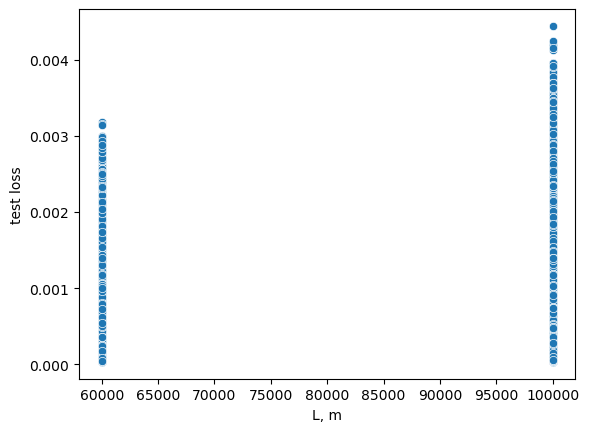

In [69]:
ax = sns.scatterplot(x=np.array(ls), y=metrics)
ax.set(xlabel='L, m', ylabel='test loss')

[Text(0.5, 0, 'L, m'), Text(0, 0.5, 'test loss')]

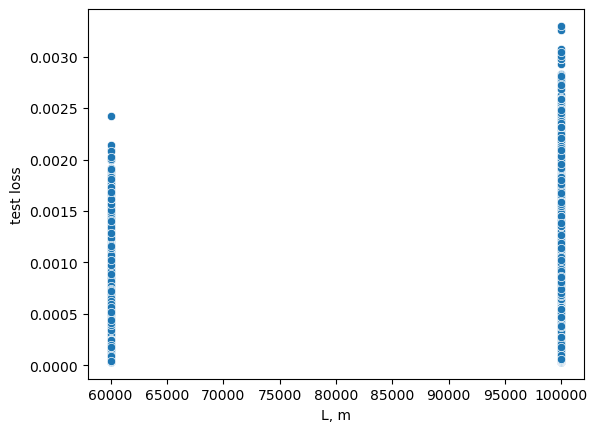

In [71]:
ax = sns.scatterplot(x=(np.array(ls_0)*(l_data_max - l_data_min) + l_data_min), y=metrics_0)
ax.set(xlabel='L, m', ylabel='test loss')

[Text(0.5, 0, 'L, m'), Text(0, 0.5, 'test loss')]

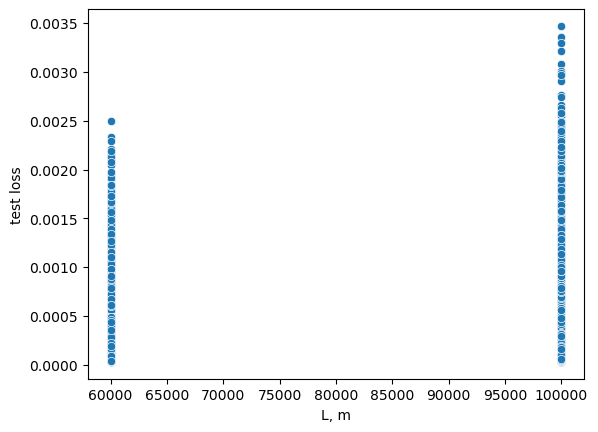

In [72]:
ax = sns.scatterplot(x=(np.array(ls_0_0)*(l_data_max - l_data_min) + l_data_min), y=metrics_0_0)
ax.set(xlabel='L, m', ylabel='test loss')

[Text(0.5, 0, 'L, m'), Text(0, 0.5, 'test loss')]

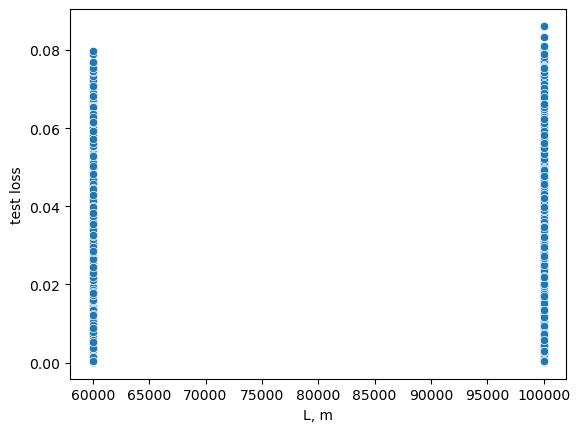

In [73]:
ax = sns.scatterplot(x=np.array(ls), y=metrics_max)
ax.set(xlabel='L, m', ylabel='test loss')

[Text(0.5, 0, 'L, m'), Text(0, 0.5, 'test loss')]

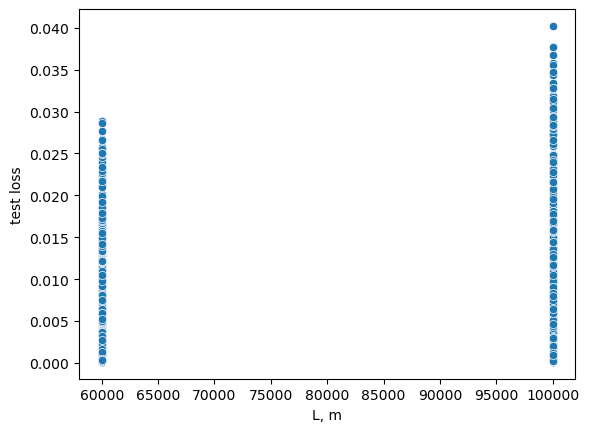

In [74]:
ax = sns.scatterplot(x=(np.array(ls_0)*(l_data_max - l_data_min) + l_data_min), y=metrics_max_0)
ax.set(xlabel='L, m', ylabel='test loss')

[Text(0.5, 0, 'L, m'), Text(0, 0.5, 'test loss')]

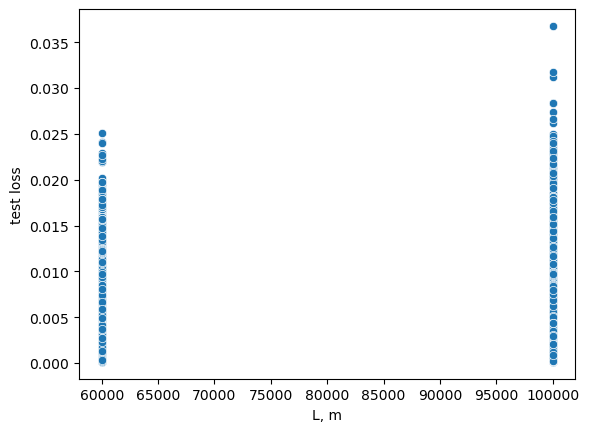

In [75]:
ax = sns.scatterplot(x=(np.array(ls_0_0)*(l_data_max - l_data_min) + l_data_min), y=metrics_max_0_0)
ax.set(xlabel='L, m', ylabel='test loss')

[Text(0.5, 0, 'D, m'), Text(0, 0.5, 'test loss')]

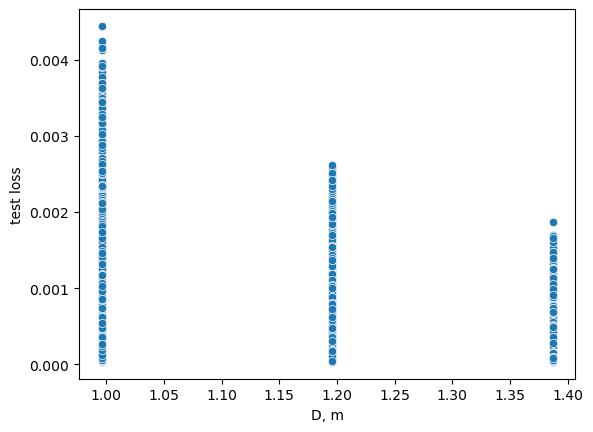

In [77]:
ax = sns.scatterplot(x=np.array(ds), y=metrics)
ax.set(xlabel='D, m', ylabel='test loss')

[Text(0.5, 0, 'D, m'), Text(0, 0.5, 'test loss')]

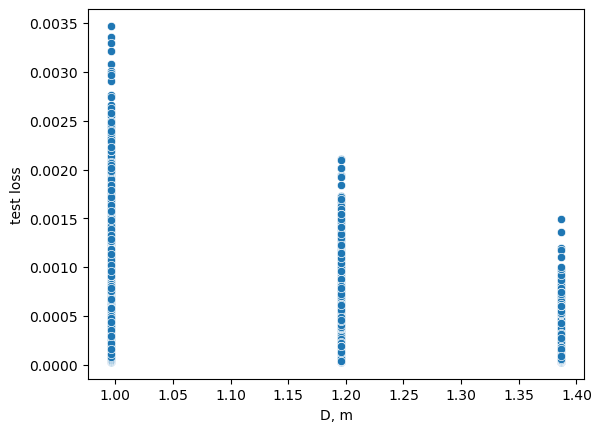

In [78]:
ax = sns.scatterplot(x=(np.array(ds_0_0)*(d_data_max - d_data_min) + d_data_min), y=metrics_0_0)
ax.set(xlabel='D, m', ylabel='test loss')

[Text(0.5, 0, 'D, m'), Text(0, 0.5, 'test loss')]

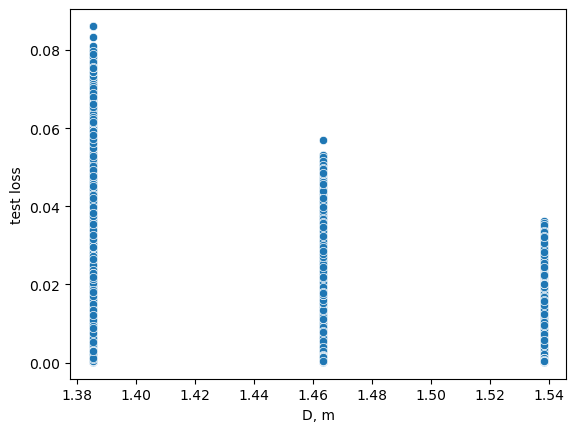

In [79]:
ax = sns.scatterplot(x=(np.array(ds)*(d_data_max - d_data_min) + d_data_min), y=metrics_max)
ax.set(xlabel='D, m', ylabel='test loss')

[Text(0.5, 0, 'D, m'), Text(0, 0.5, 'test loss')]

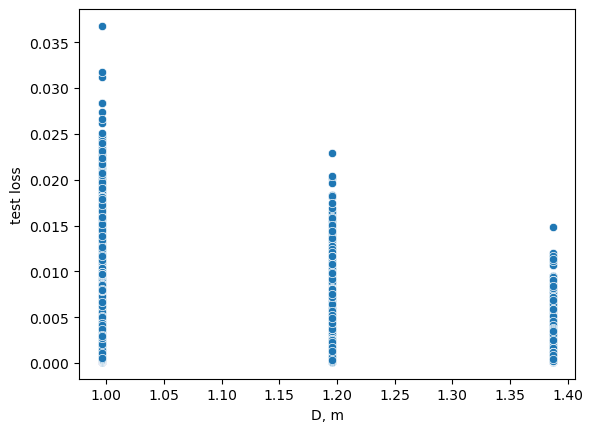

In [81]:
ax = sns.scatterplot(x=(np.array(ds_0_0)*(d_data_max - d_data_min) + d_data_min), y=metrics_max_0_0)
ax.set(xlabel='D, m', ylabel='test loss')

[Text(0.5, 0, 'T, K'), Text(0, 0.5, 'test loss')]

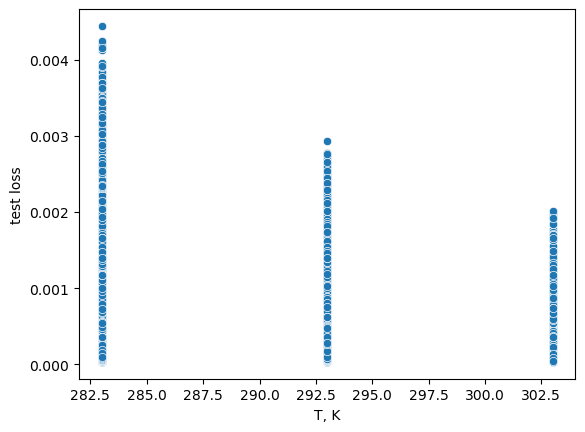

In [82]:
ax = sns.scatterplot(x=np.array(ts), y=metrics)
ax.set(xlabel='T, K', ylabel='test loss')

[Text(0.5, 0, 'T, K'), Text(0, 0.5, 'test loss')]

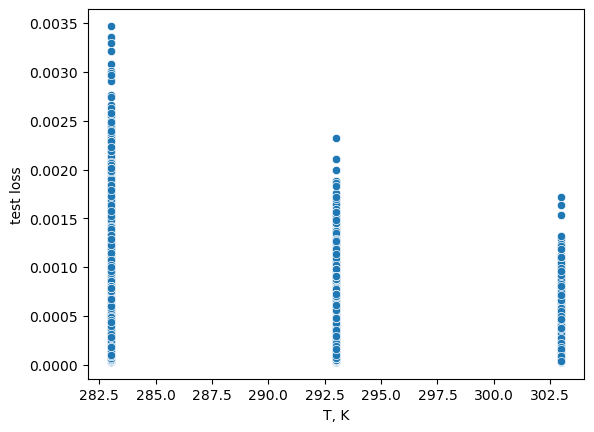

In [84]:
ax = sns.scatterplot(x=(np.array(ts_0_0)*(t_data_max - t_data_min) + t_data_min), y=metrics_0_0)
ax.set(xlabel='T, K', ylabel='test loss')

[Text(0.5, 0, 'T, K'), Text(0, 0.5, 'test loss')]

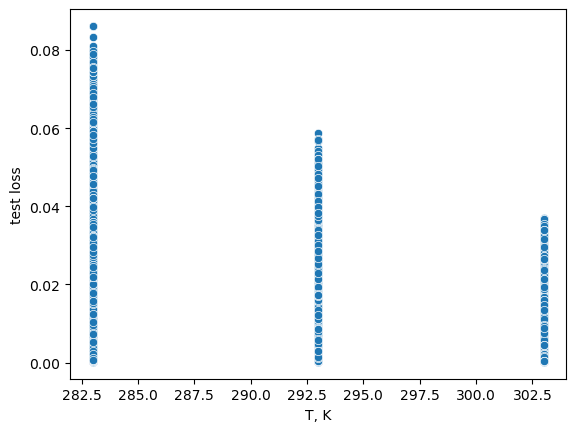

In [85]:
ax = sns.scatterplot(x=np.array(ts), y=metrics_max)
ax.set(xlabel='T, K', ylabel='test loss')

[Text(0.5, 0, 'T, K'), Text(0, 0.5, 'test loss')]

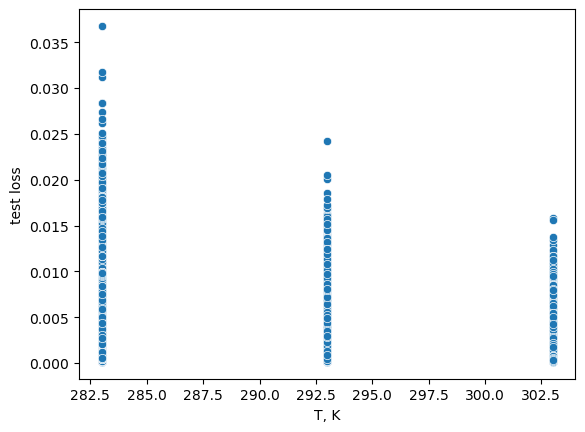

In [86]:
ax = sns.scatterplot(x=(np.array(ts_0_0)*(t_data_max - t_data_min) + t_data_min), y=metrics_max_0_0)
ax.set(xlabel='T, K', ylabel='test loss')

In [88]:
# Массив для оригинальных значений pq_data_loader_test
pq_data_loader_test_original = copy.deepcopy(pq_data_loader_test.dataset)
pq_data_loader_test_original.shape

torch.Size([28643, 25, 5])

In [89]:
# Получим оригинальные значения для массива pq_data_loader_test
min_max_list = [[min_value_p, max_value_p], [min_value_q, max_value_q], [l_data_min, l_data_max], [d_data_min, d_data_max], [t_data_min, t_data_max]]

for i in tqdm(range(len(pq_data_loader_test.dataset)), desc="Processing"):
    for j in range(len(pq_data_loader_test.dataset[i][0, :])):
        for k in range(len(pq_data_loader_test.dataset[i][:, j])):
            pq_data_loader_test_original[i][k, j] = inverse_min_max_scaling(min_max_list[j][0], min_max_list[j][1], pq_data_loader_test.dataset[i][k, j])

Processing: 100%|██████████| 28643/28643 [01:44<00:00, 274.03it/s]


In [90]:
# список для хранения датафреймов
df_list = []

# итерация по тензорам в pq_data_loader_test.dataset
for tensor in pq_data_loader_test_original:
    df_list.append(pd.DataFrame(tensor))

In [91]:
Series_tensors = pd.Series(df_list)

In [92]:
Max_APE = pd.Series(metrics_max)

In [93]:
df_worst_cases = pd.DataFrame(columns=['P_min', 'P_max', 'Q_min', 'Q_max', 'L', 'D', 'Temp'])
Max_APE_error = 0.0

for ser_index in tqdm(Series_tensors[Max_APE > Max_APE_error].index[:]):
    df_worst_cases.loc[len(df_worst_cases)] = {
        'P_min': min(Series_tensors[Max_APE > Max_APE_error][ser_index][0]),
        'P_max': max(Series_tensors[Max_APE > Max_APE_error][ser_index][0]),
        'Q_min': min(Series_tensors[Max_APE > Max_APE_error][ser_index][1]),
        'Q_max': max(Series_tensors[Max_APE > Max_APE_error][ser_index][1]),
        'L': Series_tensors[Max_APE > Max_APE_error][ser_index][2][0],
        'D': Series_tensors[Max_APE > Max_APE_error][ser_index][3][0],
        'Temp': Series_tensors[Max_APE > Max_APE_error][ser_index][4][0]
    }

100%|██████████| 28643/28643 [02:18<00:00, 206.22it/s]


In [94]:
# Сохранение в Excel
df_worst_cases.to_excel('df_worst_cases_2.xlsx', index=False)

In [95]:
# Загрузка из Excel
# df_worst_cases = pd.read_excel('df_worst_cases_2.xlsx')

In [96]:
df_worst_cases[(df_worst_cases['L'] == 60000) & (df_worst_cases['Temp'] == 283)]

P_min  P_max       Q_min       Q_max        L      D   Temp
5        6.5    7.0  109.000000  118.800003  60000.0  1.387  283.0
11       7.0    7.0   71.000000   95.600006  60000.0  1.196  283.0
15       6.5    7.5   78.300003  102.900002  60000.0  1.196  283.0
16       6.0    6.0   70.599998   75.899994  60000.0  1.196  283.0
27       7.0    7.5   79.800003  102.900002  60000.0  1.196  283.0
...      ...    ...         ...         ...      ...    ...    ...
28608    6.5    7.5  112.400002  121.000008  60000.0  1.387  283.0
28613    7.0    7.5  122.400002  141.900009  60000.0  1.387  283.0
28620    7.0    7.5  102.800003  111.799995  60000.0  1.387  283.0
28628    7.0    7.5  107.000000  149.000000  60000.0  1.387  283.0
28637    7.0    7.5   48.200001   65.099998  60000.0  0.996  283.0

[4675 rows x 7 columns]

In [97]:
df_worst_cases

P_min  P_max       Q_min       Q_max         L      D   Temp
0        7.0    7.0   79.600006   86.500000  100000.0  1.387  283.0
1        6.5    6.5   69.399994   86.100006   60000.0  1.196  293.0
2        6.0    7.0   44.500000   66.500000  100000.0  1.196  303.0
3        7.0    7.0  106.099998  114.599998   60000.0  1.387  303.0
4        6.0    6.5   90.700005  107.700005   60000.0  1.387  293.0
...      ...    ...         ...         ...       ...    ...    ...
28638    6.0    6.5   58.700001   84.000000   60000.0  1.196  293.0
28639    6.0    7.0   34.599998   40.500000  100000.0  0.996  293.0
28640    6.5    6.5   71.699997   84.199997  100000.0  1.387  293.0
28641    6.5    7.5  113.000008  135.700012   60000.0  1.387  303.0
28642    6.0    7.0   70.599998   77.300003   60000.0  1.196  303.0

[28643 rows x 7 columns]

In [98]:
df_worst_cases['D'].value_counts()

D
1.387    9694
1.196    9513
0.996    9436
Name: count, dtype: int64

In [99]:
df_worst_cases['L'].value_counts()

L
60000.0     14395
100000.0    14248
Name: count, dtype: int64

In [100]:
df_worst_cases['Temp'].value_counts()

Temp
303.0    9777
293.0    9583
283.0    9283
Name: count, dtype: int64

In [101]:
max(Max_APE)

0.08616697043180466

In [102]:
Max_APE.idxmax()

17440

In [103]:
df_worst_cases.iloc[17440]

P_min         6.000000
P_max         6.000000
Q_min        37.200001
Q_max        39.799999
L        100000.000000
D             0.996000
Temp        283.000000
Name: 17440, dtype: float64

In [104]:
max(metrics_max)

0.08616697

[Text(0.5, 0, 'MAPE, %'), Text(0, 0.5, 'Количество')]

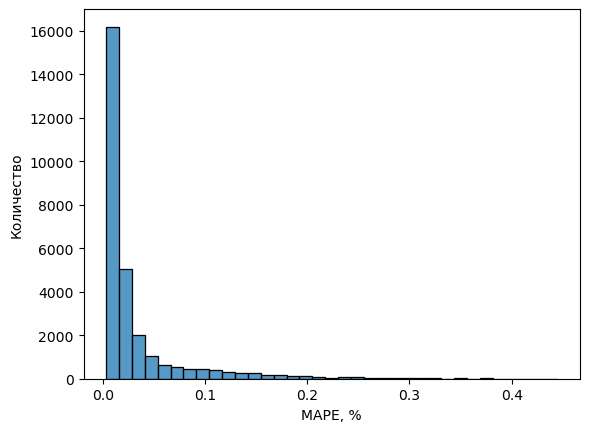

In [108]:
# MAPE для случая всех временных слоев
ax = sns.histplot(pd.Series(np.array(metrics) * 100), bins = 35)
ax.set(xlabel='MAPE, %', ylabel='Количество')

[Text(0.5, 0, 'MAPE, %'), Text(0, 0.5, 'Количество')]

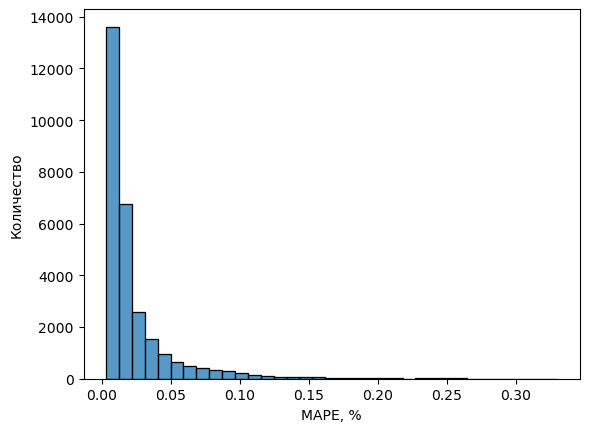

In [109]:
# MAPE с учетом исключения первых двух временных слоев (начальные условия)
ax = sns.histplot(pd.Series(np.array(metrics_0) * 100), bins = 35)
ax.set(xlabel='MAPE, %', ylabel='Количество')

[Text(0.5, 0, 'MAPE, %'), Text(0, 0.5, 'Количество')]

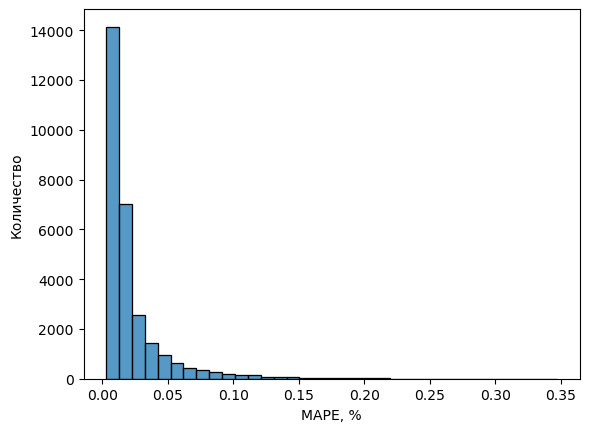

In [110]:
# MAPE с учетом дополнительного исключения последних четырех временных слоев (физические ограничения для давления и потребления для трубы 1020)
ax = sns.histplot(pd.Series(np.array(metrics_0_0) * 100), bins = 35)
ax.set(xlabel='MAPE, %', ylabel='Количество')

[Text(0.5, 0, 'Max APE, %'), Text(0, 0.5, 'Количество')]

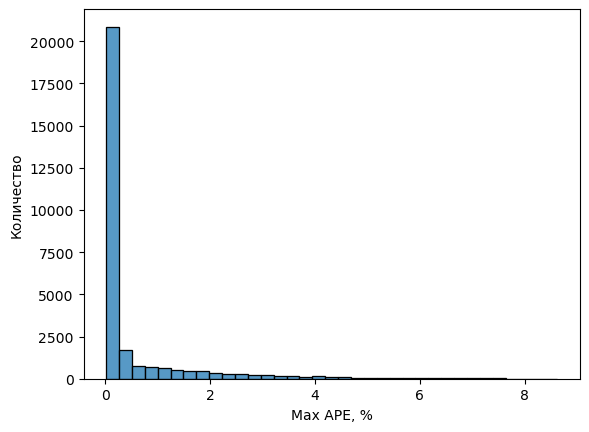

In [113]:
# max MAPE для случая всех временных слоев
ax = sns.histplot(pd.Series(np.array(metrics_max) * 100), bins = 35)
ax.set(xlabel='Max APE, %', ylabel='Количество')

[Text(0.5, 0, 'Max APE, %'), Text(0, 0.5, 'Количество')]

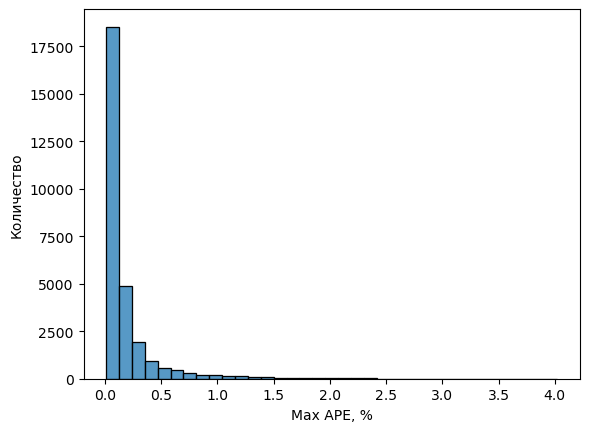

In [114]:
# max MAPE с учетом исключения первых двух временных слоев (начальные условия)
ax = sns.histplot(pd.Series(np.array(metrics_max_0) * 100), bins = 35)
ax.set(xlabel='Max APE, %', ylabel='Количество')

[Text(0.5, 0, 'Max APE, %'), Text(0, 0.5, 'Количество')]

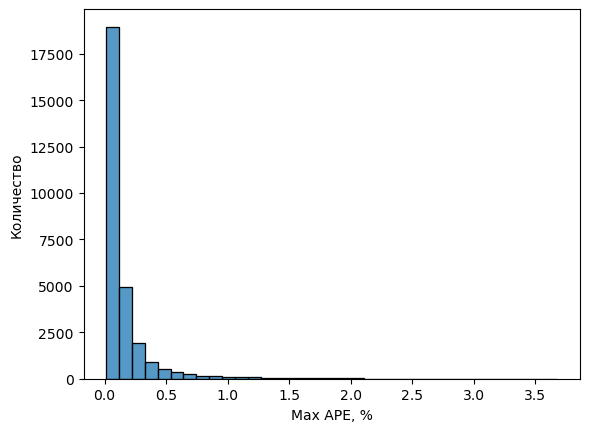

In [115]:
# max MAPE с учетом дополнительного исключения последних четырех временных слоев (физические ограничения для давления и потребления для трубы 1020)
ax = sns.histplot(pd.Series(np.array(metrics_max_0_0) * 100), bins = 35)
ax.set(xlabel='Max APE, %', ylabel='Количество')

[Text(0.5, 23.52222222222222, 'Координата, км'),
 Text(50.722222222222214, 0.5, 'Время, ч')]

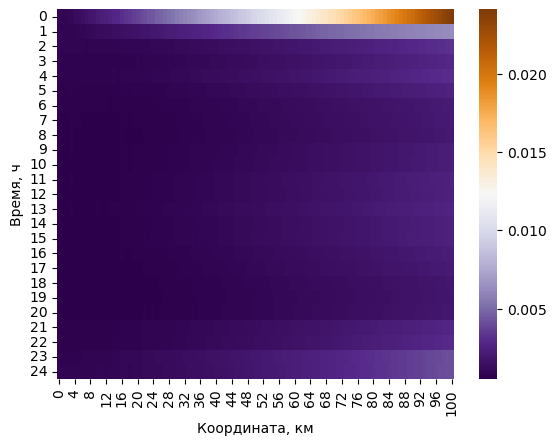

In [116]:
# Абсолютная разница для случая всех временных слоев
s = sns.heatmap(np.mean(np.array(diffs), axis=0), cmap= 'PuOr_r')
s.set(xlabel='Координата, км', ylabel='Время, ч')

[Text(0.5, 23.52222222222222, 'Координата, км'),
 Text(50.722222222222214, 0.5, 'Время, ч')]

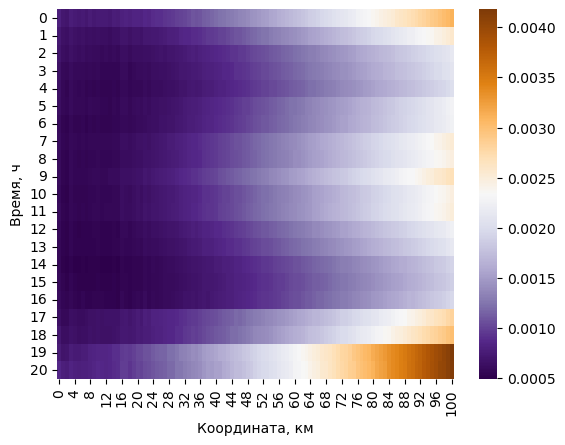

In [118]:
# Абсолютная разница с учетом исключения первых двух временных слоев (начальные условия)
diffs_without_zero_layers = [arr[2:] for arr in diffs_0]

s = sns.heatmap(np.mean(np.array(diffs_without_zero_layers), axis=0), cmap='PuOr_r')
s.set(xlabel='Координата, км', ylabel='Время, ч')

[Text(0.5, 23.52222222222222, 'Координата, км'),
 Text(50.722222222222214, 0.5, 'Время, ч')]

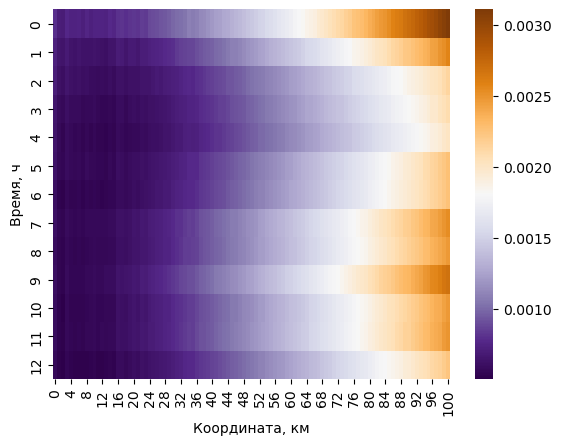

In [119]:
# Абсолютная разница с учетом дополнительного исключения последних четырех временных слоев (физические ограничения для давления и потребления для трубы 1020)
diffs_without_last_layers = [arr[2:-4] for arr in diffs_0_0]

s = sns.heatmap(np.mean(np.array(diffs_without_last_layers), axis=0), cmap='PuOr_r')
s.set(xlabel='Координата, км', ylabel='Время, ч')

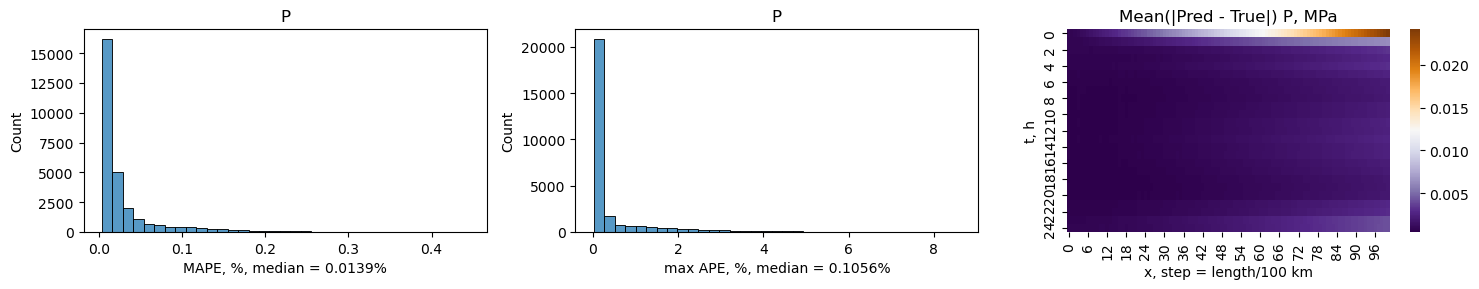

In [126]:
# для случая всех временных слоев
fig, ax =plt.subplots(1,3, figsize = (15, 3), sharex=False, sharey=False)
ax0 = sns.histplot(pd.Series(np.array(metrics) * 100), bins = 35, ax=ax[0])
ax1 = sns.histplot(pd.Series(np.array(metrics_max) * 100), bins = 35, ax=ax[1])
ax2 = sns.heatmap(np.mean(np.array(diffs), axis=0), cmap= 'PuOr_r', ax=ax[2])

ax0.set(xlabel=f'MAPE, %, median = {round(np.median(np.array(metrics)) * 100, 4)}%', ylabel='Count')
ax1.set(xlabel=f'max APE, %, median = {round(np.median(np.array(metrics_max)) * 100, 4)}%', ylabel='Count')
ax2.set(xlabel='x, step = length/100 km', ylabel='t, h')

ax0.title.set_text('P')
ax1.title.set_text('P')
ax2.title.set_text('Mean(|Pred - True|) P, MPa')

plt.tight_layout()
plt.show()

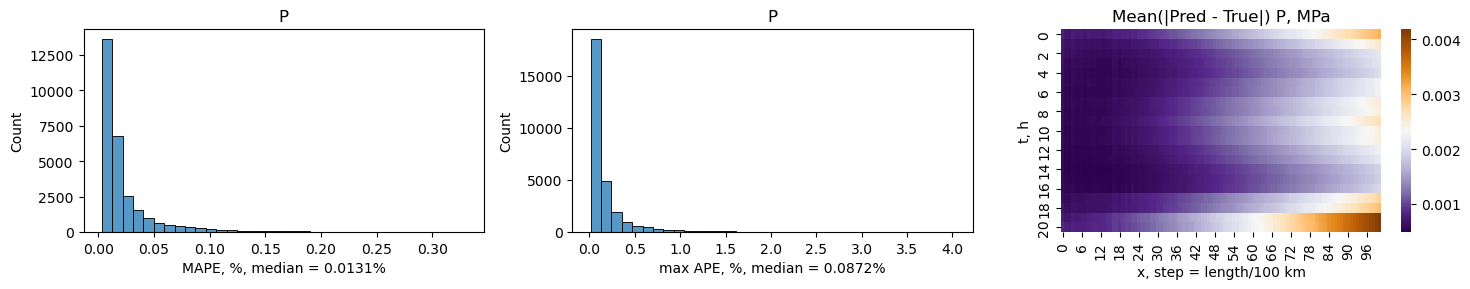

In [127]:
# с учетом исключения первых двух временных слоев (начальные условия)
fig, ax =plt.subplots(1,3, figsize = (15, 3), sharex=False, sharey=False)
ax0 = sns.histplot(pd.Series(np.array(metrics_0) * 100), bins = 35, ax=ax[0])
ax1 = sns.histplot(pd.Series(np.array(metrics_max_0) * 100), bins = 35, ax=ax[1])
ax2 = sns.heatmap(np.mean(np.array(diffs_without_zero_layers), axis=0), cmap= 'PuOr_r', ax=ax[2])

ax0.set(xlabel=f'MAPE, %, median = {round(np.median(np.array(metrics_0)) * 100, 4)}%', ylabel='Count')
ax1.set(xlabel=f'max APE, %, median = {round(np.median(np.array(metrics_max_0)) * 100, 4)}%', ylabel='Count')
ax2.set(xlabel='x, step = length/100 km', ylabel='t, h')

ax0.title.set_text('P')
ax1.title.set_text('P')
ax2.title.set_text('Mean(|Pred - True|) P, MPa')

plt.tight_layout()
plt.show()

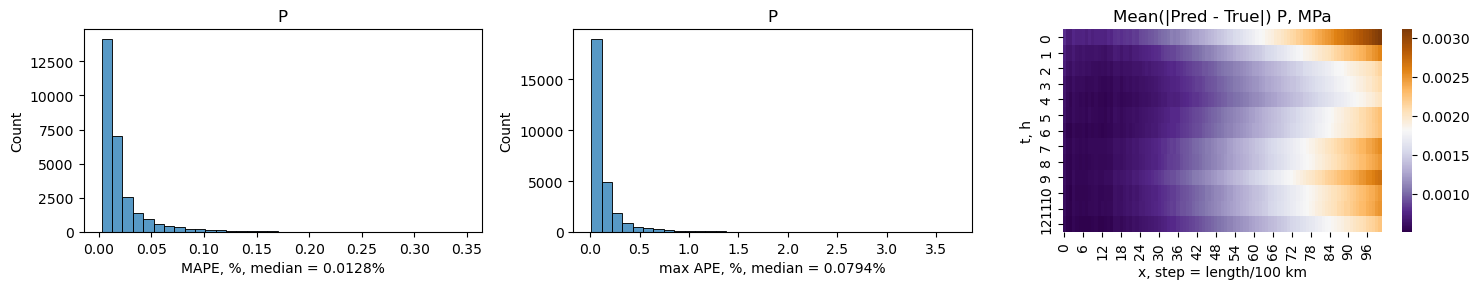

In [129]:
fig, ax =plt.subplots(1,3, figsize = (15, 3), sharex=False, sharey=False)
ax0 = sns.histplot(pd.Series(np.array(metrics_0_0) * 100), bins = 35, ax=ax[0])
ax1 = sns.histplot(pd.Series(np.array(metrics_max_0_0) * 100), bins = 35, ax=ax[1])
ax2 = sns.heatmap(np.mean(np.array(diffs_without_last_layers), axis=0), cmap= 'PuOr_r', ax=ax[2])

ax0.set(xlabel=f'MAPE, %, median = {round(np.median(np.array(metrics_0_0)) * 100, 4)}%', ylabel='Count')
ax1.set(xlabel=f'max APE, %, median = {round(np.median(np.array(metrics_max_0_0)) * 100, 4)}%', ylabel='Count')
ax2.set(xlabel='x, step = length/100 km', ylabel='t, h')

ax0.title.set_text('P')
ax1.title.set_text('P')
ax2.title.set_text('Mean(|Pred - True|) P, MPa')

plt.tight_layout()
plt.show()

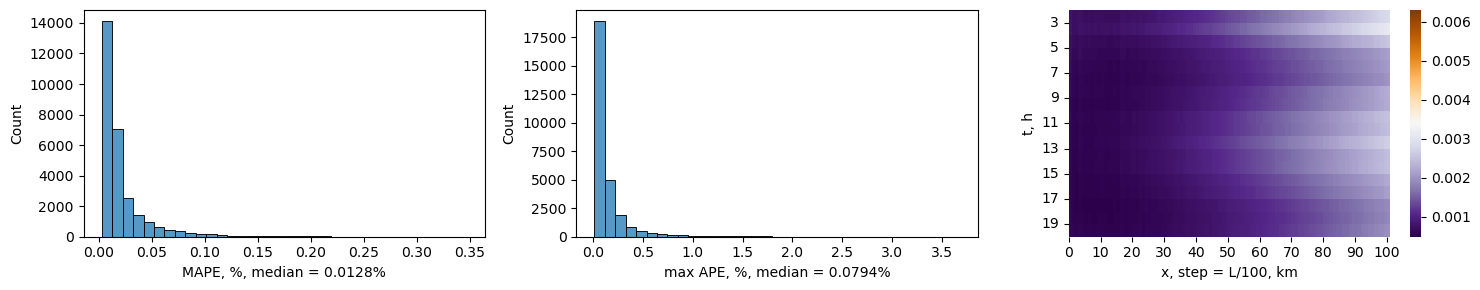

In [130]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3), sharex=False, sharey=False)

ax0 = sns.histplot(pd.Series(np.array(metrics_0_0) * 100), bins=35, ax=ax[0])
ax1 = sns.histplot(pd.Series(np.array(metrics_max_0_0) * 100), bins=35, ax=ax[1])
ax2 = sns.heatmap(np.mean(np.array(diffs)[:, 1:-4, :], axis=0), cmap='PuOr_r', ax=ax[2])

ax0.set(xlabel=f'MAPE, %, median = {round(np.median(np.array(metrics_0_0)) * 100, 4)}%', ylabel='Count')
ax1.set(xlabel=f'max APE, %, median = {round(np.median(np.array(metrics_max_0_0)) * 100, 4)}%', ylabel='Count')
ax2.set(xlabel='x, step = L/100, km', ylabel='t, h')

# ax0.set_title('P')  # изменено
# ax1.set_title('P')  # изменено
# ax2.set_title('Mean(|Pred - True|) P, MPa')  # изменено

# Устанавливаем значения и их отображение для делений оси x с меньшим размером шрифта и горизонтальным поворотом
x_ticks = np.arange(0, 101, 10)
ax2.set_xticks(x_ticks)
ax2.set_xticklabels([str(x) for x in x_ticks], fontsize=10, rotation=0)  # Уменьшаем размер шрифта и поворачиваем горизонтально


y_ticks = np.arange(1, 21, 2)
ax2.set_yticks(y_ticks)
ax2.set_yticklabels([str(y) for y in y_ticks], fontsize=10, rotation=0)  # Уменьшаем размер шрифта и поворачиваем горизонтально

# Устанавливаем лимиты для оси y, начиная с 0
ax2.set_ylim(20, 2)

plt.tight_layout()
plt.show()


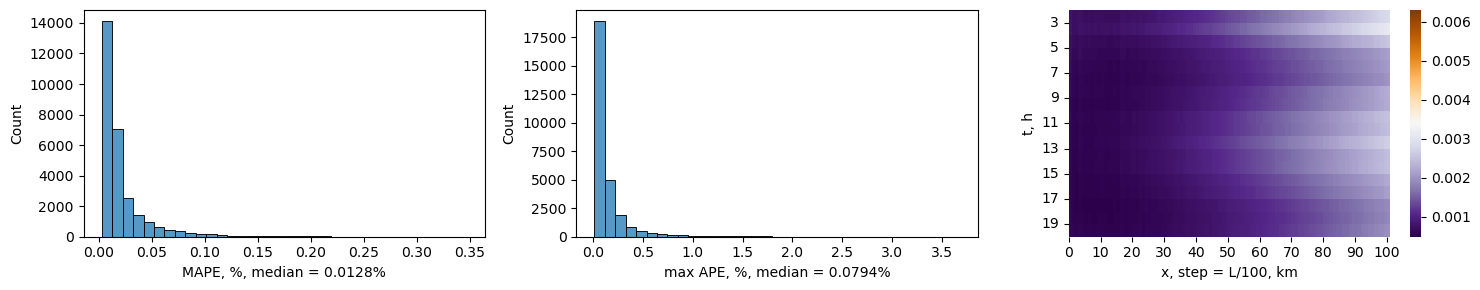

In [131]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3), sharex=False, sharey=False)

ax0 = sns.histplot(pd.Series(np.array(metrics_0_0) * 100), bins=35, ax=ax[0])
ax1 = sns.histplot(pd.Series(np.array(metrics_max_0_0) * 100), bins=35, ax=ax[1])
ax2 = sns.heatmap(np.mean(np.array(diffs)[:, 1:-4, :], axis=0), cmap='PuOr_r', ax=ax[2])

ax0.set(xlabel=f'MAPE, %, median = {round(np.median(np.array(metrics_0_0)) * 100, 4)}%', ylabel='Count')
ax1.set(xlabel=f'max APE, %, median = {round(np.median(np.array(metrics_max_0_0)) * 100, 4)}%', ylabel='Count')
ax2.set(xlabel='x, step = L/100, km', ylabel='t, h')

# ax0.set_title('P')  # изменено
# ax1.set_title('P')  # изменено
# ax2.set_title('Mean(|Pred - True|) P, MPa')  # изменено

# Устанавливаем значения и их отображение для делений оси x с меньшим размером шрифта и горизонтальным поворотом
x_ticks = np.arange(0, 101, 10)
ax2.set_xticks(x_ticks)
ax2.set_xticklabels([str(x) for x in x_ticks], fontsize=10, rotation=0)  # Уменьшаем размер шрифта и поворачиваем горизонтально


y_ticks = np.arange(1, 21, 2)
ax2.set_yticks(y_ticks)
ax2.set_yticklabels([str(y) for y in y_ticks], fontsize=10, rotation=0)  # Уменьшаем размер шрифта и поворачиваем горизонтально

# Устанавливаем лимиты для оси y, начиная с 0
ax2.set_ylim(20, 2)

plt.tight_layout()
plt.show()


## Проверка для случая всех временных слоев

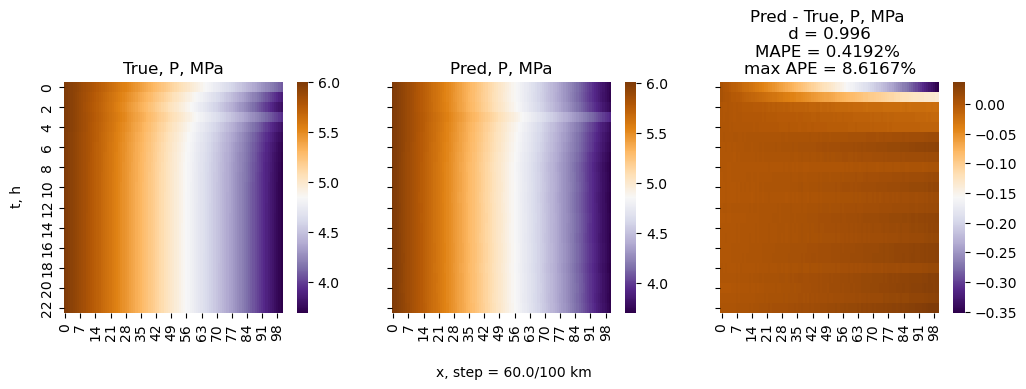

In [143]:
# худший пример с max APE для случая всех временных слоев
with torch.no_grad():
    x_data = pq_data_loader_test.dataset[np.argmax(metrics_max)][None, :, :]
    pred = model(x_data)
    y_data = p_x_data_loader_test.dataset[np.argmax(metrics_max)][:-2]
    y_true = rescale_back(y_data.numpy())
    y_pred = rescale_back(pred[:, :-2, :].numpy()[0])

l_tmp = float(x_data[0][0][-2])*(l_data_max - l_data_min) + l_data_min
d_tmp = float(x_data[0][0][-1])*(d_data_max - d_data_min) + d_data_min

fig, ax =plt.subplots(1,3, figsize = (12, 3), sharex=True, sharey=True)
ax0 = sns.heatmap(y_true, ax=ax[0],  cmap= 'PuOr_r')
ax1 = sns.heatmap(y_pred, ax=ax[1],  cmap= 'PuOr_r')
ax2 = sns.heatmap(y_pred - y_true, ax=ax[2],  cmap= 'PuOr_r')

fig.text(0.5, -0.1, f'x, step = {round(l_tmp)/1000}/100 km', ha='center')
fig.text(0.08, 0.5, 't, h', va='center', rotation='vertical')

ax0.title.set_text('True, P, MPa')
ax1.title.set_text('Pred, P, MPa')
ax2.title.set_text(f'Pred - True, P, MPa \n d = {d_tmp} \nMAPE = {round(metrics[np.argmax(metrics_max)]*100, 4)}% \nmax APE = {str(round(np.max(abs((y_pred - y_true)/y_true)*100), 4))}%')


In [144]:
max(Max_APE)

0.08616697043180466

In [145]:
Max_APE.idxmax()

17440

In [146]:
df_worst_cases.iloc[17440]

P_min         6.000000
P_max         6.000000
Q_min        37.200001
Q_max        39.799999
L        100000.000000
D             0.996000
Temp        283.000000
Name: 17440, dtype: float64

torch.Size([1, 25, 101])
torch.Size([25, 101])


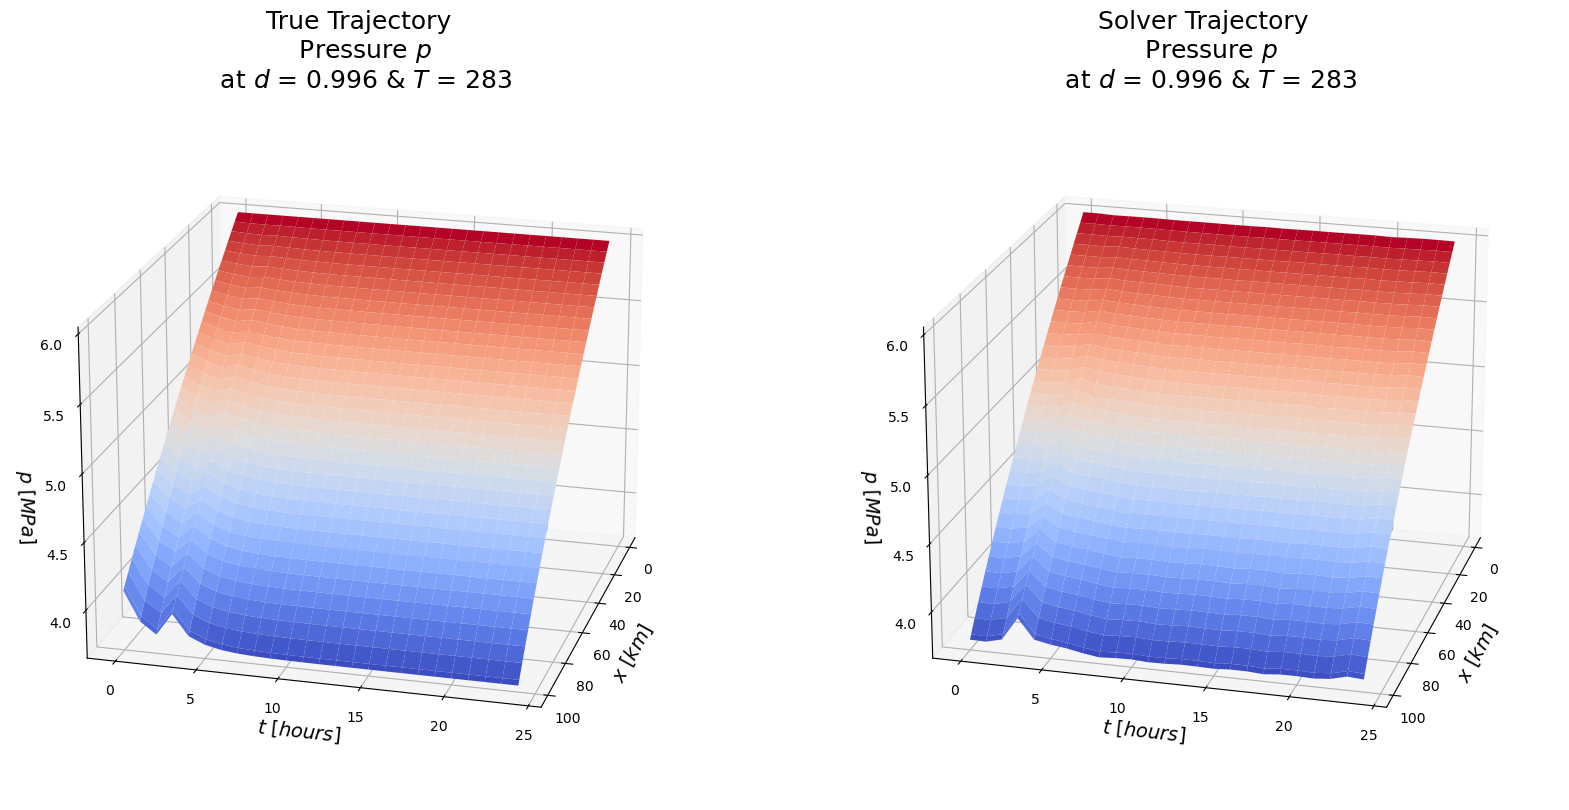

In [147]:
with torch.no_grad():
    x_data = pq_data_loader_test.dataset[17440][None, :, :]
    pred = model(x_data)
    print(pred.shape)
    y_data = p_x_data_loader_test.dataset[17440]
    print(y_data.shape)

# Применение обратного преобразования Min-Max Scaling к данным
y_data_original = inverse_min_max_scaling(min_value_p, max_value_p, y_data)
pred_original = inverse_min_max_scaling(min_value_p, max_value_p, pred[0, :, :])
l_original = inverse_min_max_scaling(l_data_min, l_data_max, x_data[:, 1, 2]) / 1000
d_original = inverse_min_max_scaling(d_data_min, d_data_max, x_data[:, 1, 3])
t_original = inverse_min_max_scaling(t_data_min, t_data_max, x_data[:, 1, 4])

#Plot True trajectory: produced by a numerical solver
# and Solver trajectory: produced by our NN
L = 101
T = 25

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.set_title(f'True Trajectory \n Pressure $p$ \n at $d$ = {round(float(d_original),3)} & $T$ = {int(t_original)}', fontsize=18)
ax2.set_title(f'Solver Trajectory \n Pressure $p$ \n at $d$ = {round(float(d_original),3)} & $T$ = {int(t_original)}', fontsize=18)

# Истинная траектория
x_data_mesh, t_data_mesh = np.meshgrid(np.linspace(0, l_original, L), np.linspace(0, 24, T))
ax1.plot_surface(x_data_mesh, t_data_mesh, y_data_original, cmap='coolwarm')

# Предсказанная траектория
ax2.plot_surface(x_data_mesh, t_data_mesh, pred_original, cmap='coolwarm')

ax1.set_xlabel('$x$ [$km$]', fontsize=14)
ax1.set_ylabel('$t$ [$hours$]', fontsize=14)
ax1.set_zlabel('$p$ [$MPa$]', fontsize=14)
ax1.view_init(elev=20, azim=15)

ax2.set_xlabel('$x$ [$km$]', fontsize=14)
ax2.set_ylabel('$t$ [$hours$]', fontsize=14)
ax2.set_zlabel('$p$ [$MPa$]', fontsize=14)
ax2.view_init(elev=20, azim=15)

plt.show();

In [148]:
y_data_original

tensor([[6.0000, 5.9839, 5.9677,  ..., 4.1335, 4.1101, 4.0866],
        [6.0000, 5.9829, 5.9657,  ..., 3.9265, 3.8980, 3.8693],
        [6.0000, 5.9822, 5.9643,  ..., 3.8419, 3.8127, 3.7833],
        ...,
        [6.0000, 5.9813, 5.9626,  ..., 3.7513, 3.7214, 3.6912],
        [6.0000, 5.9813, 5.9626,  ..., 3.7513, 3.7214, 3.6912],
        [6.0000, 5.9813, 5.9626,  ..., 3.7513, 3.7214, 3.6912]])

In [149]:
pred_original

tensor([[6.0063, 5.9857, 5.9677,  ..., 3.7942, 3.7629, 3.7344],
        [6.0061, 5.9860, 5.9673,  ..., 3.7920, 3.7610, 3.7322],
        [6.0008, 5.9821, 5.9647,  ..., 3.8189, 3.7902, 3.7614],
        ...,
        [6.0035, 5.9838, 5.9654,  ..., 3.7883, 3.7581, 3.7285],
        [6.0034, 5.9847, 5.9671,  ..., 3.8166, 3.7877, 3.7584],
        [6.0018, 5.9821, 5.9654,  ..., 3.8087, 3.7793, 3.7503]])

In [150]:
(np.round(abs((y_data_original - pred_original) / y_data_original) * 100, 2))[:5]

tensor([[0.1100, 0.0300, 0.0000, 0.0200, 0.0700, 0.1200, 0.1500, 0.1900, 0.2200,
         0.2700, 0.3300, 0.3700, 0.4000, 0.4600, 0.4900, 0.5200, 0.5700, 0.6100,
         0.6800, 0.7100, 0.7600, 0.8100, 0.8700, 0.9100, 0.9500, 1.0000, 1.0600,
         1.1100, 1.1600, 1.2200, 1.2700, 1.3200, 1.3800, 1.4200, 1.4800, 1.5600,
         1.6100, 1.6600, 1.7200, 1.7800, 1.8500, 1.9100, 1.9900, 2.0500, 2.1100,
         2.1900, 2.2500, 2.3100, 2.3800, 2.4400, 2.5200, 2.5900, 2.6700, 2.7500,
         2.8200, 2.9100, 2.9800, 3.0600, 3.1700, 3.2500, 3.3200, 3.4100, 3.4900,
         3.6000, 3.6800, 3.7700, 3.8900, 3.9700, 4.0800, 4.1900, 4.2600, 4.3900,
         4.4800, 4.6000, 4.6900, 4.8100, 4.9200, 5.0500, 5.1800, 5.2700, 5.4300,
         5.5600, 5.6800, 5.8200, 5.9700, 6.0900, 6.2300, 6.3900, 6.5300, 6.6800,
         6.8300, 7.0000, 7.1700, 7.3300, 7.5100, 7.6800, 7.8700, 8.0200, 8.2100,
         8.4500, 8.6200],
        [0.1000, 0.0500, 0.0300, 0.0200, 0.0000, 0.0400, 0.0500, 0.0800, 0.0900,
  

In [151]:
(np.round(abs((y_data_original - pred_original) / y_data_original) * 100, 2))[-5:]

tensor([[0.0300, 0.0300, 0.0100, 0.0200, 0.0300, 0.0000, 0.0100, 0.0100, 0.0000,
         0.0100, 0.0200, 0.0200, 0.0200, 0.0400, 0.0300, 0.0300, 0.0500, 0.0300,
         0.0600, 0.0600, 0.0800, 0.0800, 0.0800, 0.0800, 0.0800, 0.1000, 0.0900,
         0.0900, 0.1000, 0.1100, 0.1100, 0.1200, 0.1300, 0.1500, 0.1200, 0.1500,
         0.1600, 0.1700, 0.1700, 0.1600, 0.1800, 0.1800, 0.2000, 0.2000, 0.2100,
         0.2400, 0.2200, 0.2400, 0.2500, 0.2300, 0.2600, 0.2600, 0.2800, 0.2800,
         0.2800, 0.3100, 0.2900, 0.3100, 0.3300, 0.3300, 0.3400, 0.3400, 0.3500,
         0.3700, 0.3600, 0.3900, 0.4100, 0.4000, 0.4100, 0.4200, 0.4400, 0.4500,
         0.4600, 0.4700, 0.4800, 0.4900, 0.4800, 0.5000, 0.5400, 0.5200, 0.5500,
         0.5700, 0.5700, 0.5900, 0.6100, 0.6100, 0.6100, 0.6400, 0.6700, 0.6800,
         0.6700, 0.6800, 0.7100, 0.7400, 0.7700, 0.7500, 0.7900, 0.7900, 0.7900,
         0.8300, 0.8400],
        [0.0300, 0.0300, 0.0300, 0.0200, 0.0200, 0.0300, 0.0300, 0.0500, 0.0400,
  

## Проверка для случая с учетом исключения первых двух временных слоев (начальные условия)

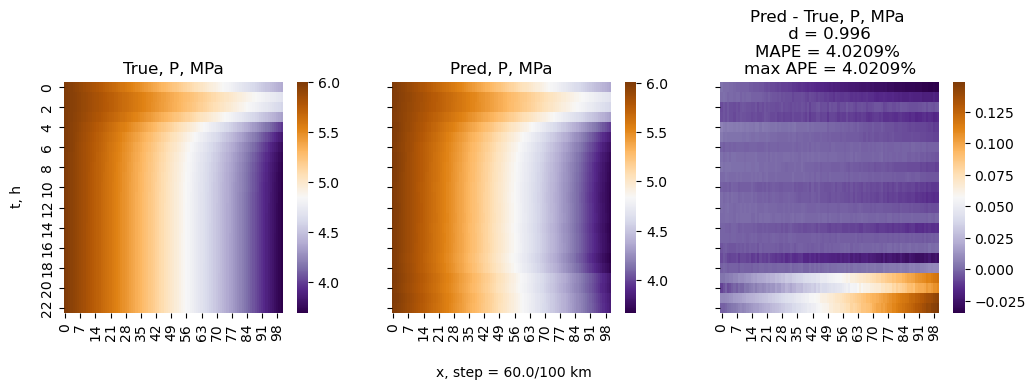

In [161]:
# худший пример с max APE с учетом исключения первых двух временных слоев (начальные условия)
with torch.no_grad():
    x_data = pq_data_loader_test.dataset[np.argmax(metrics_max_0)][None, :, :]
    pred = model(x_data)
    y_data = p_x_data_loader_test.dataset[np.argmax(metrics_max_0)][2:]
    y_true = rescale_back(y_data.numpy())
    y_pred = rescale_back(pred[:, 2:, :].numpy()[0])

l_tmp = float(x_data[0][0][-2])*(l_data_max - l_data_min) + l_data_min
d_tmp = float(x_data[0][0][-1])*(d_data_max - d_data_min) + d_data_min

fig, ax =plt.subplots(1,3, figsize = (12, 3), sharex=True, sharey=True)
ax0 = sns.heatmap(y_true, ax=ax[0],  cmap= 'PuOr_r')
ax1 = sns.heatmap(y_pred, ax=ax[1],  cmap= 'PuOr_r')
ax2 = sns.heatmap(y_pred - y_true, ax=ax[2],  cmap= 'PuOr_r')

fig.text(0.5, -0.1, f'x, step = {round(l_tmp)/1000}/100 km', ha='center')
fig.text(0.08, 0.5, 't, h', va='center', rotation='vertical')

ax0.title.set_text('True, P, MPa')
ax1.title.set_text('Pred, P, MPa')
ax2.title.set_text(f'Pred - True, P, MPa \n d = {d_tmp} \nMAPE = {round(metrics_max_0[np.argmax(metrics_max_0)]*100, 4)}% \nmax APE = {str(round(np.max(abs((y_pred - y_true)/y_true)*100), 4))}%')


In [153]:
max(metrics_max_0)

0.040209237

In [154]:
pd.Series(metrics_max_0).idxmax()

21840

In [155]:
df_worst_cases.iloc[21840]

P_min         6.000000
P_max         6.000000
Q_min        29.500000
Q_max        39.799999
L        100000.000000
D             0.996000
Temp        283.000000
Name: 21840, dtype: float64

torch.Size([1, 25, 101])
torch.Size([25, 101])


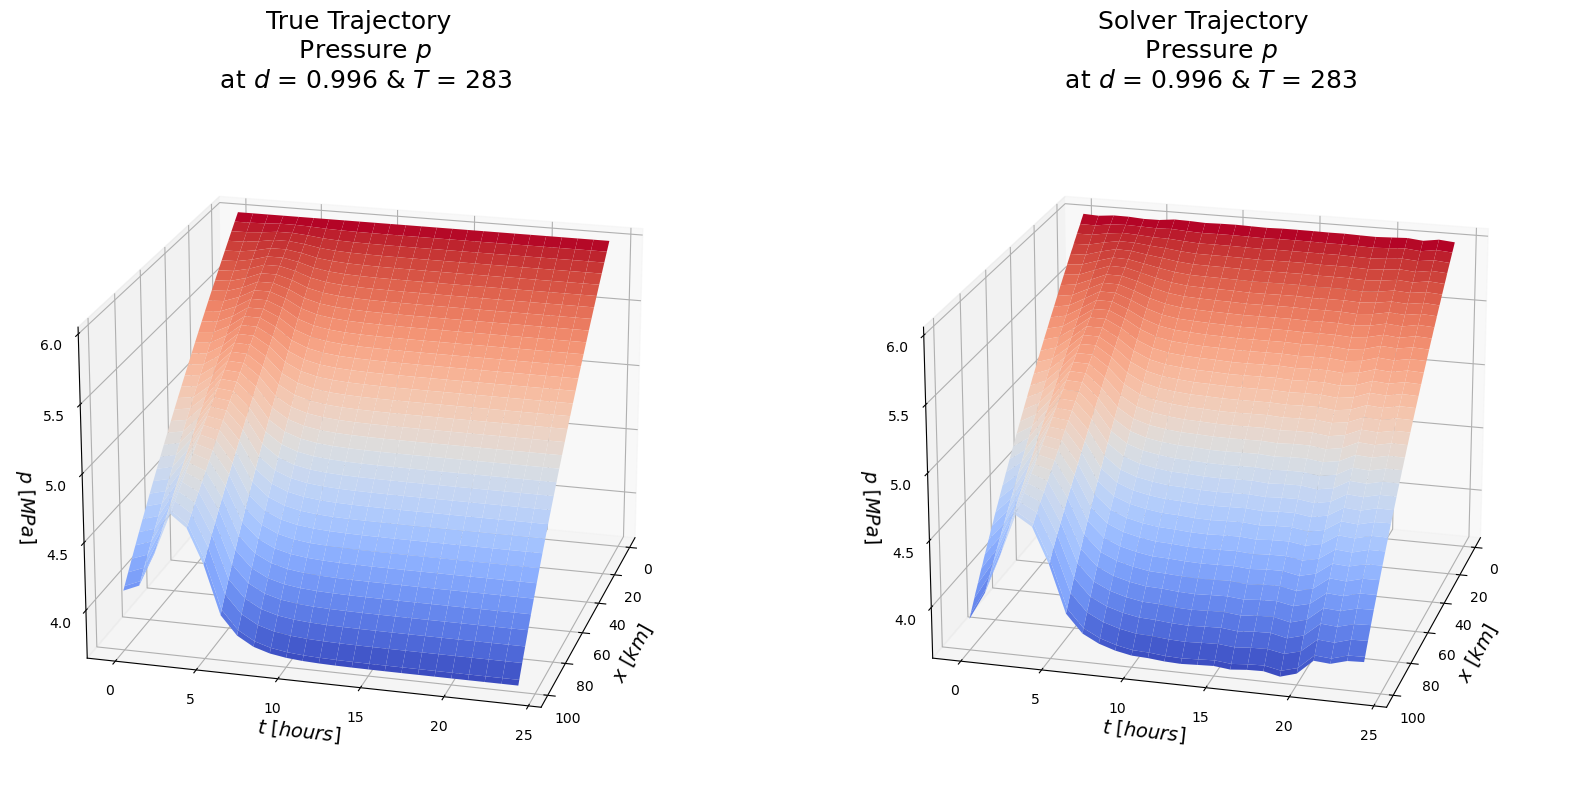

In [156]:
with torch.no_grad():
    x_data = pq_data_loader_test.dataset[21840][None, :, :]
    pred = model(x_data)
    print(pred.shape)
    y_data = p_x_data_loader_test.dataset[21840]
    print(y_data.shape)

# Применение обратного преобразования Min-Max Scaling к данным
y_data_original = inverse_min_max_scaling(min_value_p, max_value_p, y_data)
pred_original = inverse_min_max_scaling(min_value_p, max_value_p, pred[0, :, :])
l_original = inverse_min_max_scaling(l_data_min, l_data_max, x_data[:, 1, 2]) / 1000
d_original = inverse_min_max_scaling(d_data_min, d_data_max, x_data[:, 1, 3])
t_original = inverse_min_max_scaling(t_data_min, t_data_max, x_data[:, 1, 4])

#Plot True trajectory: produced by a numerical solver
# and Solver trajectory: produced by our NN
L = 101
T = 25

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.set_title(f'True Trajectory \n Pressure $p$ \n at $d$ = {round(float(d_original),3)} & $T$ = {int(t_original)}', fontsize=18)
ax2.set_title(f'Solver Trajectory \n Pressure $p$ \n at $d$ = {round(float(d_original),3)} & $T$ = {int(t_original)}', fontsize=18)

# Истинная траектория
x_data_mesh, t_data_mesh = np.meshgrid(np.linspace(0, l_original, L), np.linspace(0, 24, T))
ax1.plot_surface(x_data_mesh, t_data_mesh, y_data_original, cmap='coolwarm')

# Предсказанная траектория
ax2.plot_surface(x_data_mesh, t_data_mesh, pred_original, cmap='coolwarm')

ax1.set_xlabel('$x$ [$km$]', fontsize=14)
ax1.set_ylabel('$t$ [$hours$]', fontsize=14)
ax1.set_zlabel('$p$ [$MPa$]', fontsize=14)
ax1.view_init(elev=20, azim=15)

ax2.set_xlabel('$x$ [$km$]', fontsize=14)
ax2.set_ylabel('$t$ [$hours$]', fontsize=14)
ax2.set_zlabel('$p$ [$MPa$]', fontsize=14)
ax2.view_init(elev=20, azim=15)

plt.show();

In [157]:
y_data_original

tensor([[6.0000, 5.9839, 5.9677,  ..., 4.1335, 4.1101, 4.0866],
        [6.0000, 5.9841, 5.9682,  ..., 4.1815, 4.1593, 4.1369],
        [6.0000, 5.9855, 5.9710,  ..., 4.4252, 4.4079, 4.3906],
        ...,
        [6.0000, 5.9813, 5.9626,  ..., 3.7514, 3.7214, 3.6912],
        [6.0000, 5.9813, 5.9626,  ..., 3.7514, 3.7214, 3.6912],
        [6.0000, 5.9813, 5.9626,  ..., 3.7514, 3.7214, 3.6912]])

In [158]:
pred_original

tensor([[5.9961, 5.9779, 5.9613,  ..., 3.9078, 3.8801, 3.8509],
        [5.9900, 5.9723, 5.9580,  ..., 4.1052, 4.0822, 4.0606],
        [6.0017, 5.9864, 5.9716,  ..., 4.3914, 4.3732, 4.3559],
        ...,
        [5.9909, 5.9753, 5.9602,  ..., 3.8576, 3.8280, 3.8000],
        [6.0089, 5.9905, 5.9726,  ..., 3.8915, 3.8634, 3.8344],
        [5.9981, 5.9789, 5.9615,  ..., 3.8959, 3.8666, 3.8396]])

In [159]:
(np.round(abs((y_data_original - pred_original) / y_data_original) * 100, 2))[2:5]

tensor([[0.0300, 0.0200, 0.0100, 0.0100, 0.0000, 0.0000, 0.0200, 0.0200, 0.0200,
         0.0400, 0.0300, 0.0400, 0.0400, 0.0600, 0.0600, 0.0700, 0.0700, 0.0800,
         0.0900, 0.0900, 0.1100, 0.1200, 0.1200, 0.1400, 0.1400, 0.1500, 0.1600,
         0.1600, 0.1800, 0.1800, 0.1900, 0.2000, 0.2000, 0.2200, 0.2200, 0.2300,
         0.2500, 0.2300, 0.2500, 0.2600, 0.2700, 0.2700, 0.2800, 0.2900, 0.3100,
         0.3100, 0.3200, 0.3300, 0.3400, 0.3500, 0.3600, 0.3600, 0.3900, 0.3800,
         0.3900, 0.4100, 0.4100, 0.4200, 0.4300, 0.4400, 0.4500, 0.4500, 0.4700,
         0.4700, 0.4800, 0.5000, 0.5000, 0.5000, 0.5100, 0.5300, 0.5200, 0.5500,
         0.5700, 0.5600, 0.5600, 0.5800, 0.5700, 0.6100, 0.6000, 0.6000, 0.6300,
         0.6300, 0.6500, 0.6400, 0.6700, 0.6700, 0.6800, 0.6900, 0.6800, 0.6900,
         0.7100, 0.7100, 0.7100, 0.7500, 0.7500, 0.7500, 0.7700, 0.7700, 0.7600,
         0.7900, 0.7900],
        [0.0100, 0.0200, 0.0100, 0.0100, 0.0000, 0.0000, 0.0200, 0.0100, 0.0000,
  

In [160]:
(np.round(abs((y_data_original - pred_original) / y_data_original) * 100, 2))[-5:]

tensor([[0.0400, 0.0100, 0.0300, 0.0500, 0.0400, 0.0400, 0.0400, 0.0300, 0.0600,
         0.0300, 0.0300, 0.0400, 0.0400, 0.0400, 0.0500, 0.0300, 0.0200, 0.0400,
         0.0100, 0.0200, 0.0200, 0.0200, 0.0100, 0.0100, 0.0200, 0.0300, 0.0100,
         0.0200, 0.0200, 0.0100, 0.0300, 0.0200, 0.0100, 0.0200, 0.0100, 0.0100,
         0.0000, 0.0100, 0.0200, 0.0400, 0.0200, 0.0100, 0.0200, 0.0100, 0.0200,
         0.0100, 0.0100, 0.0000, 0.0100, 0.0200, 0.0000, 0.0100, 0.0100, 0.0100,
         0.0200, 0.0300, 0.0200, 0.0400, 0.0100, 0.0500, 0.0100, 0.0500, 0.0400,
         0.0300, 0.0300, 0.0400, 0.0500, 0.0700, 0.0500, 0.0700, 0.0700, 0.0800,
         0.0500, 0.0500, 0.0400, 0.1100, 0.0800, 0.0800, 0.0900, 0.1000, 0.1000,
         0.0800, 0.1100, 0.1400, 0.1000, 0.0900, 0.1000, 0.1600, 0.1400, 0.1600,
         0.1300, 0.1300, 0.1600, 0.1700, 0.1900, 0.2000, 0.2500, 0.2200, 0.2400,
         0.2400, 0.2500],
        [0.0500, 0.0500, 0.0800, 0.0900, 0.1000, 0.1100, 0.1500, 0.1400, 0.1900,
  

## Проверка для случая с учетом дополнительного исключения последних четырех временных слоев (физические ограничения для давления и потребления для трубы 1020)

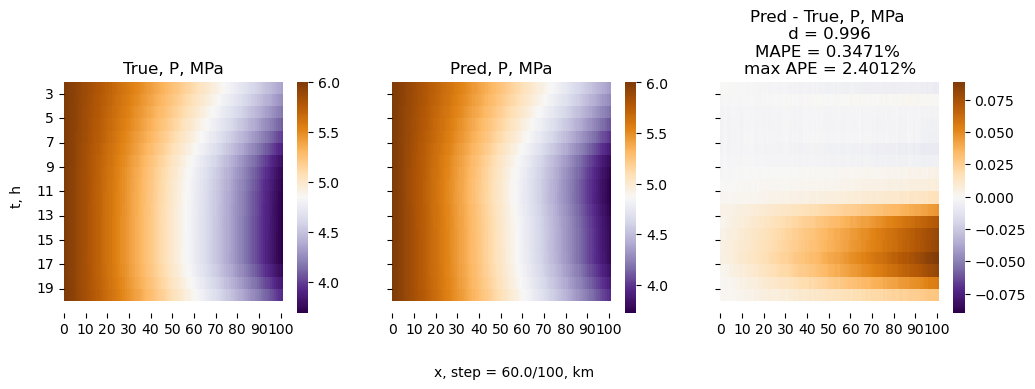

In [162]:
# худший пример с MAPE с учетом дополнительного исключения последних четырех временных слоев (физические ограничения для давления и потребления для трубы 1020)
with torch.no_grad():
    x_data = pq_data_loader_test.dataset[np.argmax(metrics_0_0)][None, :, :]
    pred = model(x_data)
    y_data = p_x_data_loader_test.dataset[np.argmax(metrics_0_0)][1:-4]
    y_true = rescale_back(y_data.numpy())
    y_pred = rescale_back(pred[:, 1:-4, :].numpy()[0])

l_tmp = float(x_data[0][0][-2])*(l_data_max - l_data_min) + l_data_min
d_tmp = float(x_data[0][0][-1])*(d_data_max - d_data_min) + d_data_min

fig, ax =plt.subplots(1,3, figsize = (12, 3), sharex=True, sharey=True)
ax0 = sns.heatmap(y_true, ax=ax[0],  cmap= 'PuOr_r')
ax1 = sns.heatmap(y_pred, ax=ax[1],  cmap= 'PuOr_r')
ax2 = sns.heatmap(y_pred - y_true, ax=ax[2],  cmap= 'PuOr_r')

fig.text(0.5, -0.1, f'x, step = {round(l_tmp)/1000}/100, km', ha='center')
fig.text(0.08, 0.5, 't, h', va='center', rotation='vertical')

# Устанавливаем значения и их отображение для делений оси x с меньшим размером шрифта и горизонтальным поворотом
x_ticks = np.arange(0, 101, 10)
ax0.set_xticks(x_ticks)
ax0.set_xticklabels([str(x) for x in x_ticks], fontsize=10, rotation=0)  # Уменьшаем размер шрифта и поворачиваем горизонтально
ax1.set_xticks(x_ticks)
ax1.set_xticklabels([str(x) for x in x_ticks], fontsize=10, rotation=0)  # Уменьшаем размер шрифта и поворачиваем горизонтально
ax2.set_xticks(x_ticks)
ax2.set_xticklabels([str(x) for x in x_ticks], fontsize=10, rotation=0)  # Уменьшаем размер шрифта и поворачиваем горизонтально


# Устанавливаем значения и их отображение для делений оси y
y_ticks = np.arange(1, 21, 2)
ax0.set_yticks(y_ticks)
ax0.set_yticklabels([str(y) for y in y_ticks], fontsize=10, rotation=0)

# Устанавливаем лимиты для оси y, начиная с 0
ax0.set_ylim(21, 2)



ax0.title.set_text('True, P, MPa')
ax1.title.set_text('Pred, P, MPa')
ax2.title.set_text(f'Pred - True, P, MPa \n d = {d_tmp} \nMAPE = {round(metrics_0_0[np.argmax(metrics_0_0)]*100, 4)}% \nmax APE = {str(round(np.max(abs((y_pred - y_true)/y_true)*100), 4))}%')

# plt.tight_layout()
# plt.show()


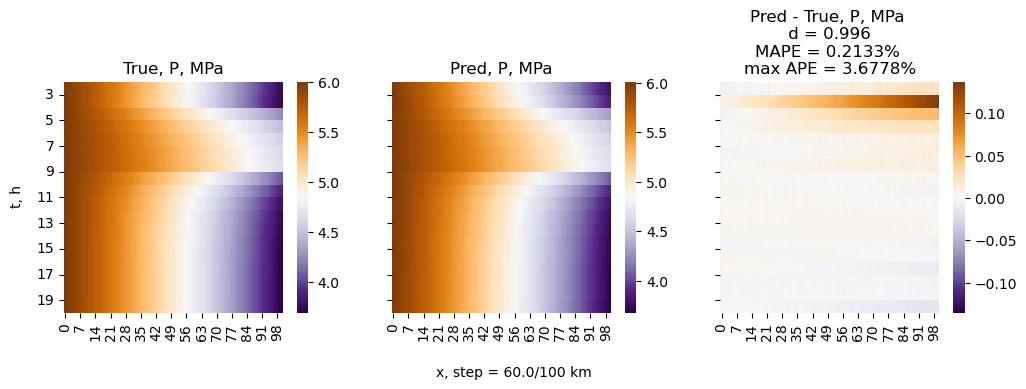

In [164]:
# худший пример с max APE с учетом дополнительного исключения последних четырех временных слоев (физические ограничения для давления и потребления для трубы 1020)
with torch.no_grad():
    x_data = pq_data_loader_test.dataset[np.argmax(metrics_max_0_0)][None, :, :]
    pred = model(x_data)
    y_data = p_x_data_loader_test.dataset[np.argmax(metrics_max_0_0)][1:-4]
    y_true = rescale_back(y_data.numpy())
    y_pred = rescale_back(pred[:, 1:-4, :].numpy()[0])

l_tmp = float(x_data[0][0][-2])*(l_data_max - l_data_min) + l_data_min
d_tmp = float(x_data[0][0][-1])*(d_data_max - d_data_min) + d_data_min

fig, ax =plt.subplots(1,3, figsize = (12, 3), sharex=True, sharey=True)
ax0 = sns.heatmap(y_true, ax=ax[0],  cmap= 'PuOr_r')
ax1 = sns.heatmap(y_pred, ax=ax[1],  cmap= 'PuOr_r')
ax2 = sns.heatmap(y_pred - y_true, ax=ax[2],  cmap= 'PuOr_r')

fig.text(0.5, -0.1, f'x, step = {round(l_tmp)/1000}/100 km', ha='center')
fig.text(0.08, 0.5, 't, h', va='center', rotation='vertical')
-4
# Устанавливаем значения и их отображение для делений оси y
y_ticks = np.arange(1, 21, 2)
ax0.set_yticks(y_ticks)
ax0.set_yticklabels([str(y) for y in y_ticks], fontsize=10, rotation=0)

# Устанавливаем лимиты для оси y, начиная с 0
ax0.set_ylim(20, 2)

ax0.title.set_text('True, P, MPa')
ax1.title.set_text('Pred, P, MPa')
ax2.title.set_text(f'Pred - True, P, MPa \n d = {d_tmp} \nMAPE = {round(metrics_0_0[np.argmax(metrics_max_0_0)]*100, 4)}% \nmax APE = {str(round(np.max(abs((y_pred - y_true)/y_true)*100), 4))}%')


In [165]:
max(metrics_0_0)*100

0.34710653126239777

In [166]:
pd.Series(metrics_0_0).idxmax()

23692

torch.Size([1, 25, 101])
torch.Size([25, 101])


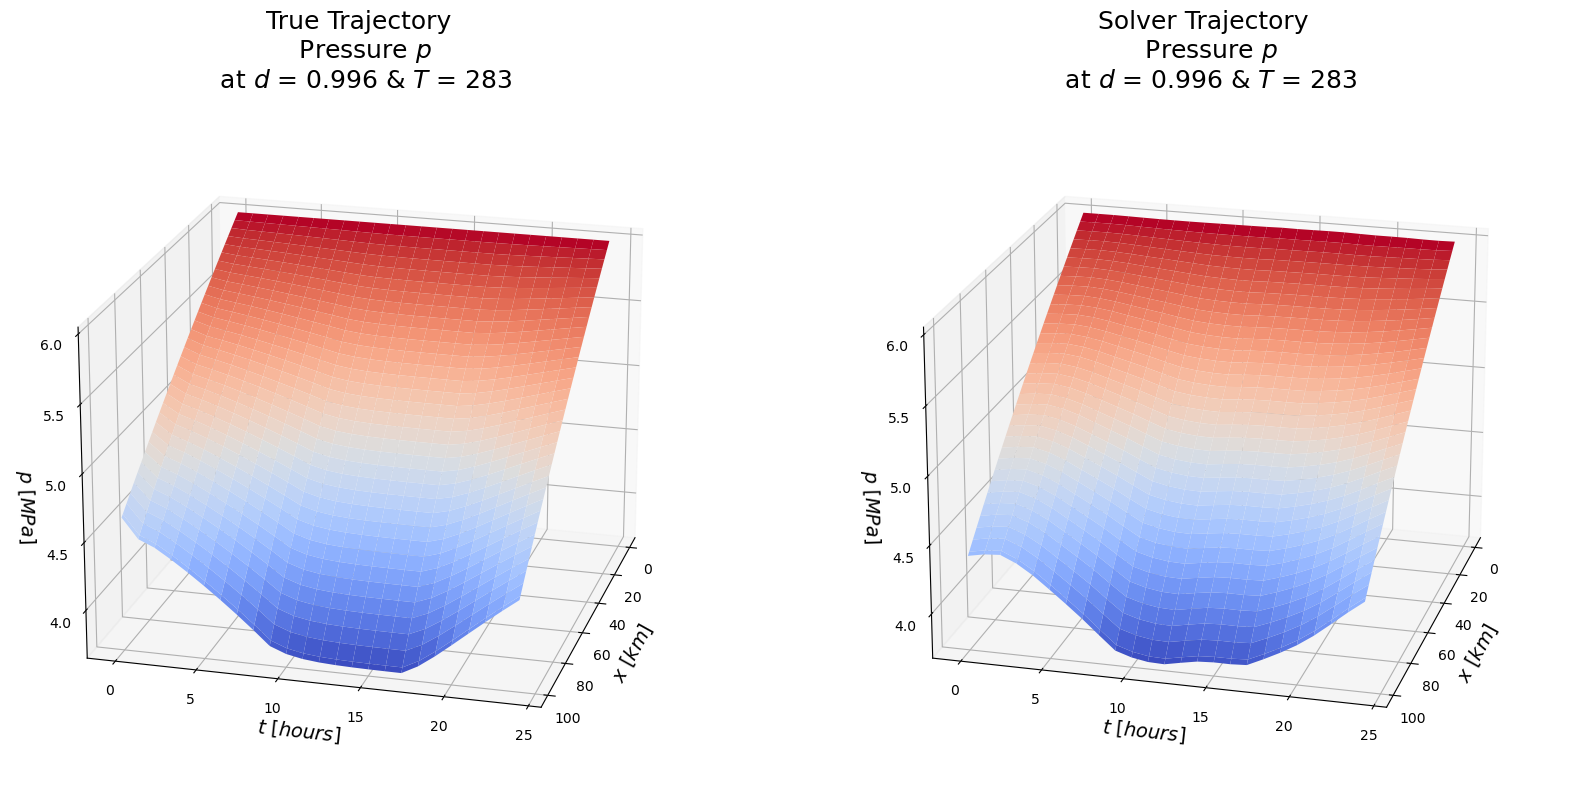

In [167]:
with torch.no_grad():
    x_data = pq_data_loader_test.dataset[23692][None, :, :]
    pred = model(x_data)
    print(pred.shape)
    y_data = p_x_data_loader_test.dataset[23692]
    print(y_data.shape)

# Применение обратного преобразования Min-Max Scaling к данным
y_data_original = inverse_min_max_scaling(min_value_p, max_value_p, y_data)
pred_original = inverse_min_max_scaling(min_value_p, max_value_p, pred[0, :, :])
l_original = inverse_min_max_scaling(l_data_min, l_data_max, x_data[:, 1, 2]) / 1000
d_original = inverse_min_max_scaling(d_data_min, d_data_max, x_data[:, 1, 3])
t_original = inverse_min_max_scaling(t_data_min, t_data_max, x_data[:, 1, 4])

#Plot True trajectory: produced by a numerical solver
# and Solver trajectory: produced by our NN
L = 101
T = 25

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.set_title(f'True Trajectory \n Pressure $p$ \n at $d$ = {round(float(d_original),3)} & $T$ = {int(t_original)}', fontsize=18)
ax2.set_title(f'Solver Trajectory \n Pressure $p$ \n at $d$ = {round(float(d_original),3)} & $T$ = {int(t_original)}', fontsize=18)

# Истинная траектория
x_data_mesh, t_data_mesh = np.meshgrid(np.linspace(0, l_original, L), np.linspace(0, 24, T))
ax1.plot_surface(x_data_mesh, t_data_mesh, y_data_original, cmap='coolwarm')

# Предсказанная траектория
ax2.plot_surface(x_data_mesh, t_data_mesh, pred_original, cmap='coolwarm')

ax1.set_xlabel('$x$ [$km$]', fontsize=14)
ax1.set_ylabel('$t$ [$hours$]', fontsize=14)
ax1.set_zlabel('$p$ [$MPa$]', fontsize=14)
ax1.view_init(elev=20, azim=15)

ax2.set_xlabel('$x$ [$km$]', fontsize=14)
ax2.set_ylabel('$t$ [$hours$]', fontsize=14)
ax2.set_zlabel('$p$ [$MPa$]', fontsize=14)
ax2.view_init(elev=20, azim=15)

plt.show();

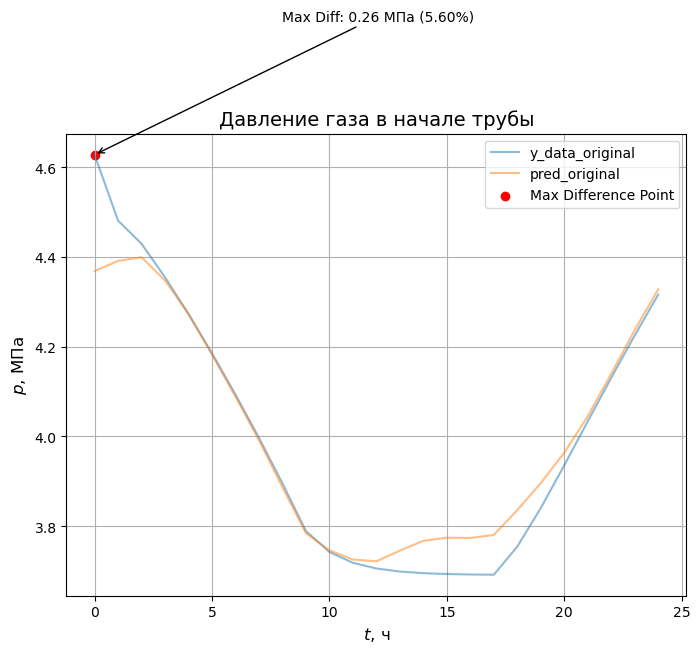

In [168]:
Tt = 24 * 60 * 60
nt = 24
t = np.linspace(0, Tt, nt + 1)

# Создаем объект Axes
fig, ax = plt.subplots(figsize=(8, 6))

# График для y_data_original
y_data = np.array(y_data_original)[:, 100]
ax.plot(t / 3600, y_data, label='y_data_original', alpha=0.5)

# График для pred_original
pred_data = np.array(pred_original)[:, 100]
ax.plot(t / 3600, pred_data, label='pred_original', alpha=0.5)

# Находим точку с максимальной разницей
max_diff_index = np.argmax(np.abs(y_data - pred_data))
max_diff_x = t[max_diff_index] / 3600
max_diff_y = y_data[max_diff_index] - pred_data[max_diff_index]

# Выводим точку с максимальной разницей
ax.scatter(max_diff_x, y_data[max_diff_index], color='red', label='Max Difference Point')

# Аннотируем значения по x и y
annotation_text = f'Max Diff: {max_diff_y:.2f} МПа ({(max_diff_y / y_data[max_diff_index] * 100):.2f}%)'
ax.annotate(annotation_text, (max_diff_x, y_data[max_diff_index]),
            xytext=(max_diff_x + 8, y_data[max_diff_index] + 0.3), arrowprops=dict(facecolor='black', arrowstyle='->'))

# Настройка отображения
ax.set_title('Давление газа в начале трубы', fontsize=14)
ax.set_xlabel('$t$, ч', fontsize=12)
ax.set_ylabel('$p$, МПа', fontsize=12)
ax.grid(True)
ax.legend()

# Показываем график
plt.show()

In [395]:
max(metrics_max_0_0)*100

3.6777541041374207

In [169]:
pd.Series(metrics_max_0_0).idxmax()

16138

In [170]:
df_worst_cases.iloc[16138]

P_min         6.000000
P_max         6.000000
Q_min        32.099998
Q_max        39.799999
L        100000.000000
D             0.996000
Temp        283.000000
Name: 16138, dtype: float64

torch.Size([1, 25, 101])
torch.Size([25, 101])


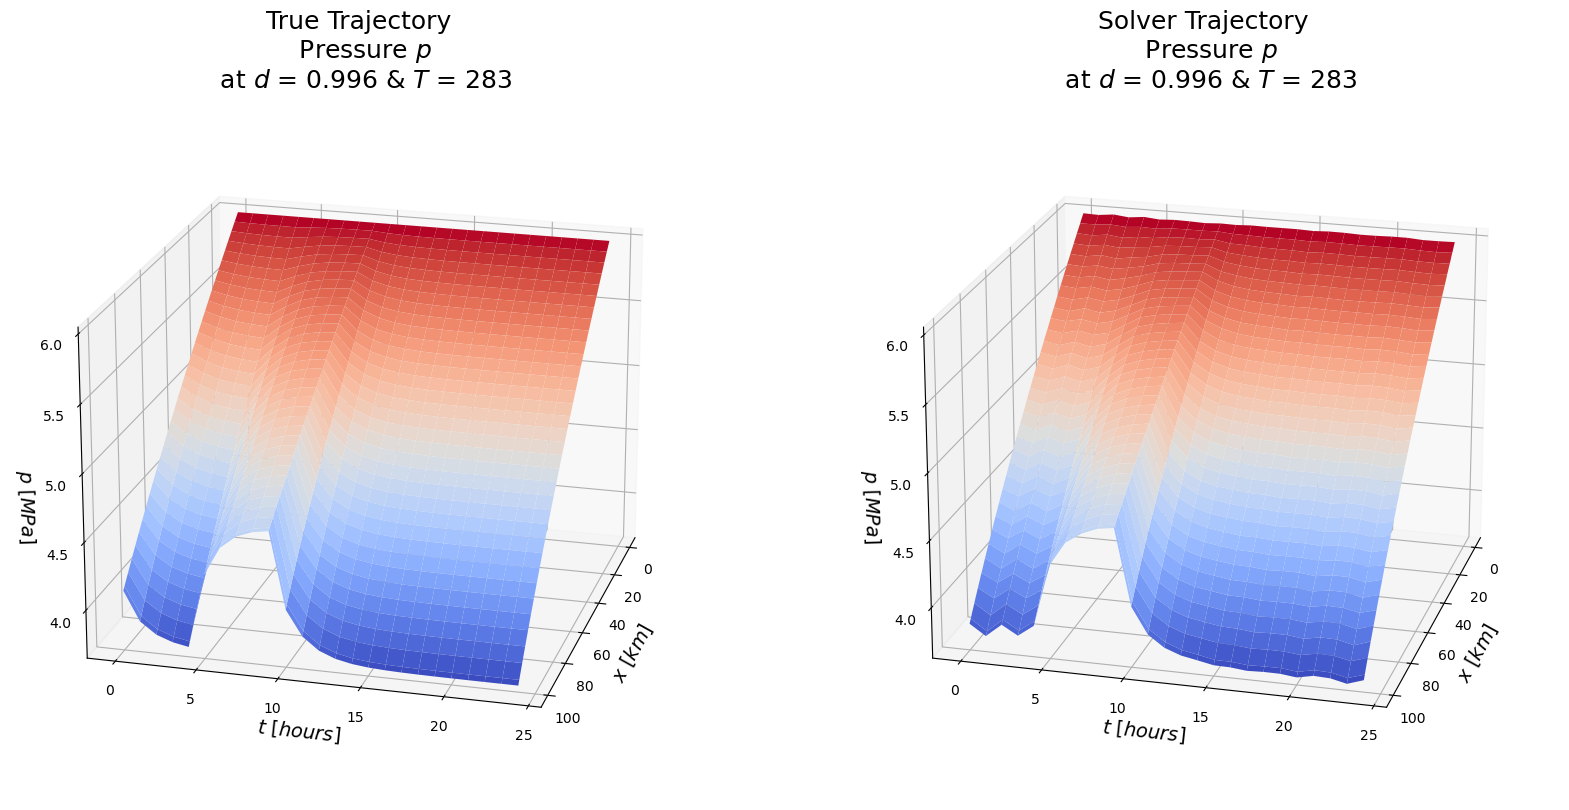

In [173]:
with torch.no_grad():
    x_data = pq_data_loader_test.dataset[16138][None, :, :]
    pred = model(x_data)
    print(pred.shape)
    y_data = p_x_data_loader_test.dataset[16138]
    print(y_data.shape)

# Применение обратного преобразования Min-Max Scaling к данным
y_data_original = inverse_min_max_scaling(min_value_p, max_value_p, y_data)
pred_original = inverse_min_max_scaling(min_value_p, max_value_p, pred[0, :, :])
l_original = inverse_min_max_scaling(l_data_min, l_data_max, x_data[:, 1, 2]) / 1000
d_original = inverse_min_max_scaling(d_data_min, d_data_max, x_data[:, 1, 3])
t_original = inverse_min_max_scaling(t_data_min, t_data_max, x_data[:, 1, 4])

#Plot True trajectory: produced by a numerical solver
# and Solver trajectory: produced by our NN
L = 101
T = 25

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.set_title(f'True Trajectory \n Pressure $p$ \n at $d$ = {round(float(d_original),3)} & $T$ = {int(t_original)}', fontsize=18)
ax2.set_title(f'Solver Trajectory \n Pressure $p$ \n at $d$ = {round(float(d_original),3)} & $T$ = {int(t_original)}', fontsize=18)

# Истинная траектория
x_data_mesh, t_data_mesh = np.meshgrid(np.linspace(0, l_original, L), np.linspace(0, 24, T))
ax1.plot_surface(x_data_mesh, t_data_mesh, y_data_original, cmap='coolwarm')

# Предсказанная траектория
ax2.plot_surface(x_data_mesh, t_data_mesh, pred_original, cmap='coolwarm')

ax1.set_xlabel('$x$ [$km$]', fontsize=14)
ax1.set_ylabel('$t$ [$hours$]', fontsize=14)
ax1.set_zlabel('$p$ [$MPa$]', fontsize=14)
ax1.view_init(elev=20, azim=15)

ax2.set_xlabel('$x$ [$km$]', fontsize=14)
ax2.set_ylabel('$t$ [$hours$]', fontsize=14)
ax2.set_zlabel('$p$ [$MPa$]', fontsize=14)
ax2.view_init(elev=20, azim=15)

plt.show();

In [174]:
y_data_original

tensor([[6.0000, 5.9839, 5.9677,  ..., 4.1335, 4.1101, 4.0866],
        [6.0000, 5.9829, 5.9657,  ..., 3.9265, 3.8980, 3.8693],
        [6.0000, 5.9822, 5.9643,  ..., 3.8419, 3.8127, 3.7833],
        ...,
        [6.0000, 5.9813, 5.9626,  ..., 3.7515, 3.7216, 3.6914],
        [6.0000, 5.9813, 5.9626,  ..., 3.7514, 3.7215, 3.6913],
        [6.0000, 5.9813, 5.9626,  ..., 3.7514, 3.7215, 3.6913]])

In [175]:
pred_original

tensor([[5.9984, 5.9818, 5.9645,  ..., 3.8738, 3.8458, 3.8182],
        [5.9945, 5.9781, 5.9622,  ..., 3.7934, 3.7623, 3.7377],
        [6.0070, 5.9876, 5.9705,  ..., 3.8928, 3.8638, 3.8360],
        ...,
        [5.9945, 5.9763, 5.9589,  ..., 3.7539, 3.7260, 3.6954],
        [5.9948, 5.9779, 5.9579,  ..., 3.7284, 3.6990, 3.6677],
        [5.9975, 5.9784, 5.9597,  ..., 3.7696, 3.7379, 3.7081]])

In [176]:
inverse_min_max_scaling(min_value_q, max_value_q, x_data[0][:, 1])

tensor([39.8000, 39.8000, 39.8000, 39.8000, 39.8000, 32.1000, 32.1000, 32.1000,
        32.1000, 32.1000, 39.8000, 39.8000, 39.8000, 39.8000, 39.8000, 39.8000,
        39.8000, 39.8000, 39.8000, 39.8000, 39.8000, 39.8000, 39.8000, 39.8000,
        39.8000])

In [177]:
(np.round(abs((y_data_original - pred_original) / y_data_original) * 100, 2))[2:7]

tensor([[0.1200, 0.0900, 0.1000, 0.1300, 0.1200, 0.1300, 0.1300, 0.1400, 0.1600,
         0.1400, 0.1500, 0.1400, 0.1600, 0.1500, 0.1700, 0.1700, 0.1800, 0.1900,
         0.1800, 0.2000, 0.2100, 0.2000, 0.2000, 0.2100, 0.2200, 0.2400, 0.2300,
         0.2400, 0.2500, 0.2500, 0.2700, 0.2600, 0.2700, 0.2800, 0.2900, 0.2900,
         0.2900, 0.3000, 0.3200, 0.3300, 0.3400, 0.3300, 0.3500, 0.3500, 0.3700,
         0.3700, 0.3800, 0.4000, 0.4000, 0.4000, 0.4300, 0.4400, 0.4500, 0.4500,
         0.4500, 0.4700, 0.4800, 0.4800, 0.4900, 0.5000, 0.5400, 0.5300, 0.5600,
         0.5600, 0.5700, 0.6000, 0.6000, 0.6200, 0.6300, 0.6300, 0.6700, 0.6700,
         0.7100, 0.7200, 0.7500, 0.7300, 0.7700, 0.7700, 0.8000, 0.8400, 0.8300,
         0.8600, 0.8900, 0.8900, 0.9200, 0.9600, 0.9700, 0.9800, 1.0300, 1.0500,
         1.0800, 1.1000, 1.1300, 1.1600, 1.1800, 1.2200, 1.2200, 1.3000, 1.3300,
         1.3400, 1.3900],
        [0.1000, 0.1000, 0.1200, 0.0100, 0.0400, 0.0800, 0.0800, 0.0500, 0.0100,
  

In [178]:
(np.round(abs((y_data_original - pred_original) / y_data_original) * 100, 2))[-5:]

tensor([[0.0400, 0.0300, 0.0300, 0.0300, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0000, 0.0000, 0.0000, 0.0100, 0.0100, 0.0100, 0.0000, 0.0100,
         0.0100, 0.0100, 0.0200, 0.0200, 0.0200, 0.0300, 0.0400, 0.0400, 0.0400,
         0.0400, 0.0500, 0.0500, 0.0700, 0.0500, 0.0500, 0.0600, 0.0600, 0.0800,
         0.0700, 0.0600, 0.0900, 0.0900, 0.1000, 0.0800, 0.1000, 0.1000, 0.1200,
         0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1300, 0.1300, 0.1400, 0.1400,
         0.1500, 0.1500, 0.1500, 0.1400, 0.1700, 0.1700, 0.1900, 0.1800, 0.1800,
         0.1900, 0.2000, 0.2000, 0.2100, 0.2000, 0.2300, 0.2400, 0.2200, 0.2500,
         0.2500, 0.2600, 0.2600, 0.2400, 0.2700, 0.2800, 0.2800, 0.2800, 0.3000,
         0.3300, 0.3200, 0.3000, 0.3400, 0.3500, 0.3600, 0.3400, 0.3600, 0.3700,
         0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4100, 0.4100, 0.4200, 0.4300,
         0.4400, 0.4500],
        [0.0400, 0.0300, 0.0400, 0.0400, 0.0300, 0.0200, 0.0300, 0.0400, 0.0400,
  

In [179]:
y_data_original[1:, :]

tensor([[6.0000, 5.9829, 5.9657,  ..., 3.9265, 3.8980, 3.8693],
        [6.0000, 5.9822, 5.9643,  ..., 3.8419, 3.8127, 3.7833],
        [6.0000, 5.9818, 5.9635,  ..., 3.7990, 3.7695, 3.7397],
        ...,
        [6.0000, 5.9813, 5.9626,  ..., 3.7515, 3.7216, 3.6914],
        [6.0000, 5.9813, 5.9626,  ..., 3.7514, 3.7215, 3.6913],
        [6.0000, 5.9813, 5.9626,  ..., 3.7514, 3.7215, 3.6913]])

## ПОДБОР СЦЕНАРИЯ (СТАТЬЯ)

torch.Size([1, 25, 101])
torch.Size([25, 101])


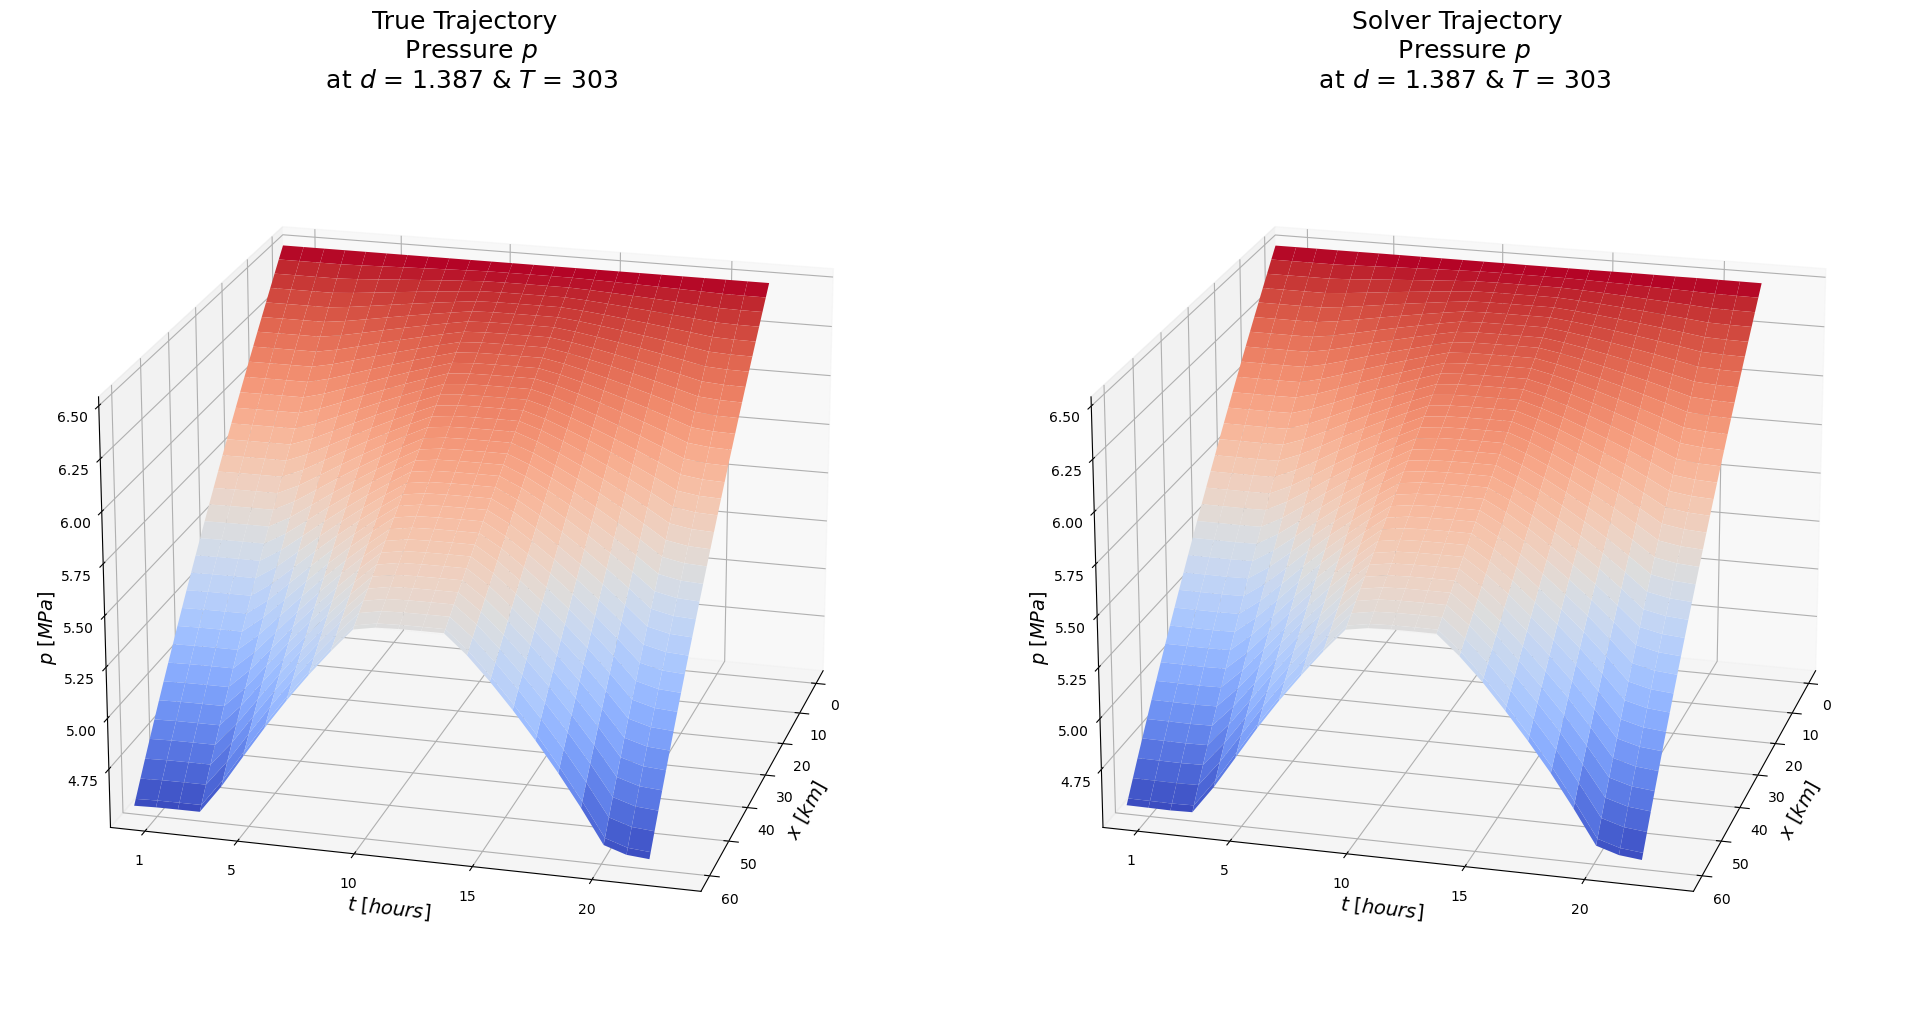

In [180]:
scen_num = 36

with torch.no_grad():
    x_data = pq_data_loader_test.dataset[scen_num][None, :, :]
    pred = model(x_data)
    print(pred.shape)
    y_data = p_x_data_loader_test.dataset[scen_num]
    print(y_data.shape)

# Применение обратного преобразования Min-Max Scaling к данным
y_data_original = inverse_min_max_scaling(min_value_p, max_value_p, y_data)
pred_original = inverse_min_max_scaling(min_value_p, max_value_p, pred[0, :, :])
l_original = inverse_min_max_scaling(l_data_min, l_data_max, x_data[:, 1, 2]) / 1000
d_original = inverse_min_max_scaling(d_data_min, d_data_max, x_data[:, 1, 3])
t_original = inverse_min_max_scaling(t_data_min, t_data_max, x_data[:, 1, 4])

#Plot True trajectory: produced by a numerical solver
# and Solver trajectory: produced by our NN
L = 101
T = 24

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.set_title(f'True Trajectory \n Pressure $p$ \n at $d$ = {round(float(d_original),3)} & $T$ = {int(t_original)}', fontsize=18)
ax2.set_title(f'Solver Trajectory \n Pressure $p$ \n at $d$ = {round(float(d_original),3)} & $T$ = {int(t_original)}', fontsize=18)

# Истинная траектория
x_data_mesh, t_data_mesh = np.meshgrid(np.linspace(0, l_original, L), np.linspace(0, 22, T))
ax1.plot_surface(x_data_mesh, t_data_mesh, y_data_original[1:, :], cmap='coolwarm')

# Предсказанная траектория
ax2.plot_surface(x_data_mesh, t_data_mesh, pred_original[1:, :], cmap='coolwarm')

ax1.set_xlabel('$x$ [$km$]', fontsize=14)
ax1.set_ylabel('$t$ [$hours$]', fontsize=14)
ax1.set_zlabel('$p$ [$MPa$]', fontsize=14)
ax1.view_init(elev=20, azim=15)

ax2.set_xlabel('$x$ [$km$]', fontsize=14)
ax2.set_ylabel('$t$ [$hours$]', fontsize=14)
ax2.set_zlabel('$p$ [$MPa$]', fontsize=14)
ax2.view_init(elev=20, azim=15)


# Поворачиваем метки оси z
ax1.zaxis.set_rotate_label(False)  # Отключаем автоматический поворот
ax1.zaxis.label.set_rotation(90)   # Задаем угол поворота

ax2.zaxis.set_rotate_label(False)
ax2.zaxis.label.set_rotation(90)

# Устанавливаем лимиты для оси y, начиная с 0
y_ticks = [1, 5, 10, 15, 20]
ax1.set_yticks(y_ticks)
ax1.set_ylim(0, 24)

ax2.set_yticks(y_ticks)
ax2.set_ylim(0, 24)

plt.tight_layout()
plt.show();

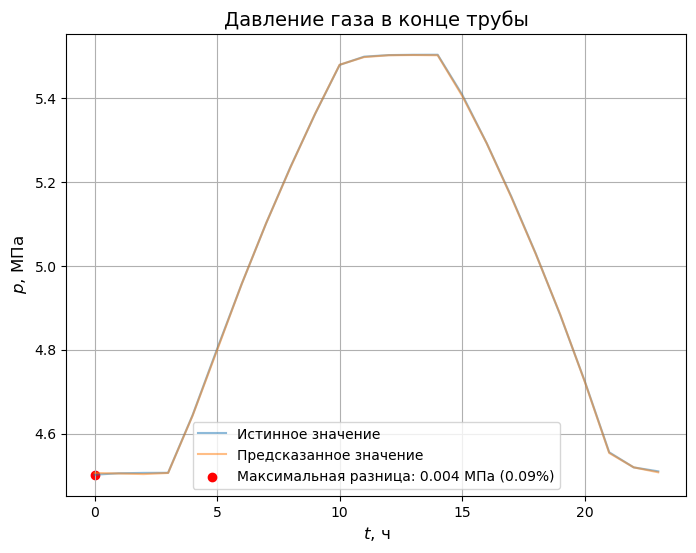

In [181]:
Tt = 23 * 60 * 60
nt = 23
t = np.linspace(0, Tt, nt + 1)

# Создаем объект Axes
fig, ax = plt.subplots(figsize=(8, 6))

# График для y_data_original
y_data = np.array(y_data_original)[1:, 100]
ax.plot(t / 3600, y_data, label='Истинное значение', alpha=0.5)

# График для pred_original
pred_data = np.array(pred_original)[1:, 100]
ax.plot(t / 3600, pred_data, label='Предсказанное значение', alpha=0.5)

# Находим точку с максимальной разницей
max_diff_index = np.argmax(np.abs(y_data - pred_data))
max_diff_x = t[max_diff_index] / 3600
max_diff_y = abs(y_data[max_diff_index] - pred_data[max_diff_index])

# Выводим точку с максимальной разницей
ax.scatter(max_diff_x, y_data[max_diff_index], color='red', label=f'Максимальная разница: {max_diff_y:.3f} МПа ({(max_diff_y / y_data[max_diff_index] * 100):.2f}%)')

# Аннотируем значения по x и y
# annotation_text = f'Максимальная разница: {max_diff_y:.3f} МПа ({(max_diff_y / y_data[max_diff_index] * 100):.2f}%)'
# ax.annotate(annotation_text, (max_diff_x, y_data[max_diff_index]),
#             xytext=(max_diff_x + 5, y_data[max_diff_index] - 0.03), arrowprops=dict(facecolor='black', arrowstyle='->'))

# Настройка отображения
ax.set_title('Давление газа в конце трубы', fontsize=14)
ax.set_xlabel('$t$, ч', fontsize=12)
ax.set_ylabel('$p$, МПа', fontsize=12)
ax.grid(True)
ax.legend()

# Показываем график
plt.show()

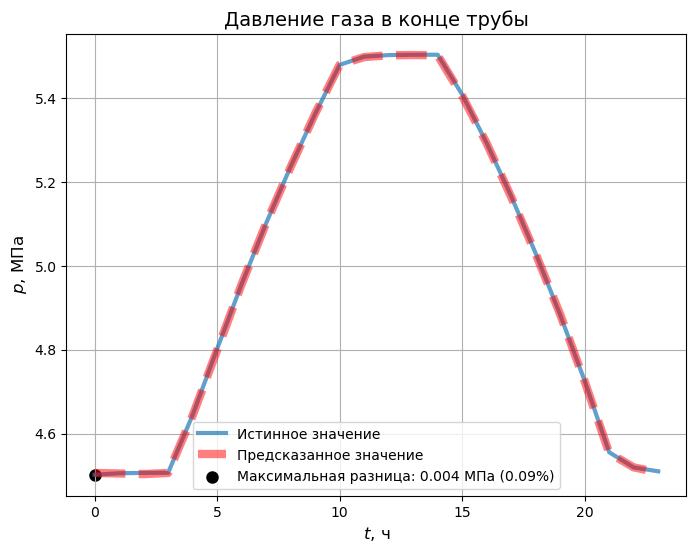

In [183]:
Tt = 23 * 60 * 60
nt = 23
t = np.linspace(0, Tt, nt + 1)

# Создаем объект Axes
fig, ax = plt.subplots(figsize=(8, 6))

# График для y_data_original
y_data = np.array(y_data_original)[1:, 100]
ax.plot(t / 3600, y_data, label='Истинное значение', alpha=0.7, linewidth=3)

# График для pred_original
pred_data = np.array(pred_original)[1:, 100]
ax.plot(t / 3600, pred_data, label='Предсказанное значение', alpha=0.5, color='red', linestyle='--', linewidth=6)

# Находим точку с максимальной разницей
max_diff_index = np.argmax(np.abs(y_data - pred_data))
max_diff_x = t[max_diff_index] / 3600
max_diff_y = abs(y_data[max_diff_index] - pred_data[max_diff_index])

# Выводим точку с максимальной разницей
ax.scatter(max_diff_x, y_data[max_diff_index], color='black', label=f'Максимальная разница: {max_diff_y:.3f} МПа ({(max_diff_y / y_data[max_diff_index] * 100):.2f}%)', linewidth=3)

# Настройка отображения
ax.set_title('Давление газа в конце трубы', fontsize=14)
ax.set_xlabel('$t$, ч', fontsize=12)
ax.set_ylabel('$p$, МПа', fontsize=12)
ax.grid(True)
ax.legend()

# Показываем график
plt.show()


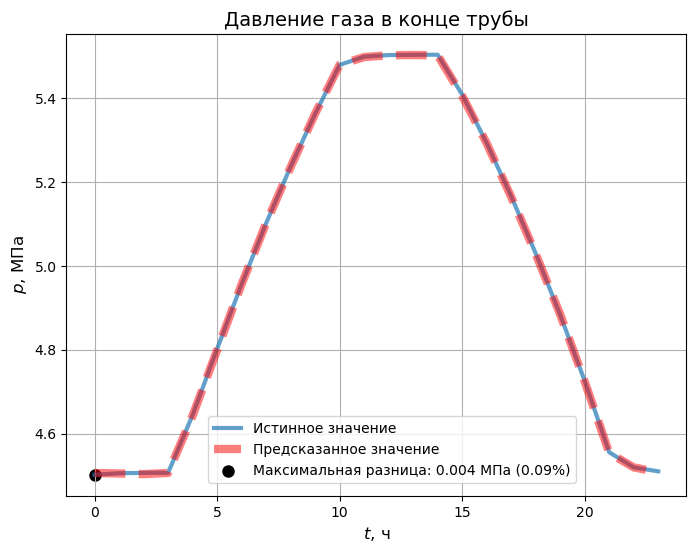

In [184]:
Tt = 23 * 60 * 60
nt = 23
t = np.linspace(0, Tt, nt + 1)

# Создаем объект Axes
fig, ax = plt.subplots(figsize=(8, 6))

# График для y_data_original
y_data = np.array(y_data_original)[1:, 100]
ax.plot(t / 3600, y_data, label='Истинное значение', alpha=0.7, linewidth=3)

# График для pred_original
pred_data = np.array(pred_original)[1:, 100]
ax.plot(t / 3600, pred_data, label='Предсказанное значение', alpha=0.5, color='red', linestyle='--', linewidth=6)

# Находим точку с максимальной разницей
max_diff_index = np.argmax(np.abs(y_data - pred_data))
max_diff_x = t[max_diff_index] / 3600
max_diff_y = abs(y_data[max_diff_index] - pred_data[max_diff_index])

# Выводим точку с максимальной разницей
ax.scatter(max_diff_x, y_data[max_diff_index], color='black', label=f'Максимальная разница: {max_diff_y:.3f} МПа ({(max_diff_y / y_data[max_diff_index] * 100):.2f}%)', linewidth=3)

# Настройка отображения
ax.set_title('Давление газа в конце трубы', fontsize=14)
ax.set_xlabel('$t$, ч', fontsize=12)
ax.set_ylabel('$p$, МПа', fontsize=12)
ax.grid(True)

# Переместить легенду чуть правее
ax.legend(loc='center', bbox_to_anchor=(0.525, 0.1))

# Показываем график
plt.show()


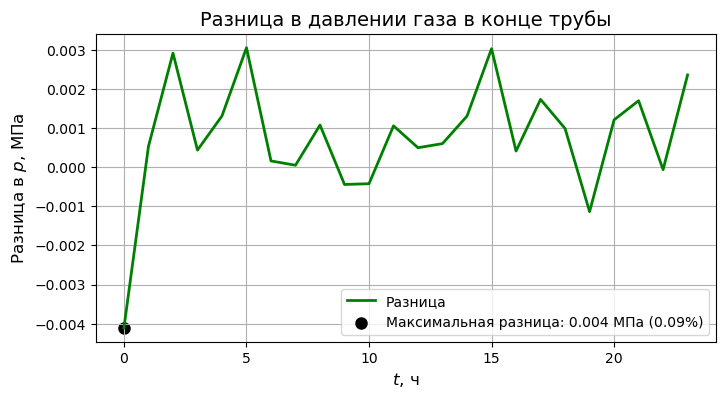

In [185]:
# Вычисляем разницу между y_data и pred_data
difference = y_data - pred_data

# Создаем новый объект Axes для графика разницы
fig_diff, ax_diff = plt.subplots(figsize=(8, 4))

# График для разницы
ax_diff.plot(t / 3600, difference, label='Разница', color='green', linewidth=2)

# Выводим точку с максимальной разницей
ax_diff.scatter(max_diff_x, difference[max_diff_index], color='black', label=f'Максимальная разница: {max_diff_y:.3f} МПа ({(max_diff_y / y_data[max_diff_index] * 100):.2f}%)', linewidth=3)

# Аннотируем значение разницы
# annotation_text_diff = f'Максимальная разница: {max_diff_y:.3f} МПа ({(max_diff_y / y_data[max_diff_index] * 100):.2f}%)'
# ax_diff.annotate(annotation_text_diff, (max_diff_x, difference[max_diff_index]),
#                  xytext=(max_diff_x -14, difference[max_diff_index] +0.00),
#                  arrowprops=dict(facecolor='black', arrowstyle='->'))

# Настройка отображения
ax_diff.set_title('Разница в давлении газа в конце трубы', fontsize=14)
ax_diff.set_xlabel('$t$, ч', fontsize=12)
ax_diff.set_ylabel('Разница в $p$, МПа', fontsize=12)
ax_diff.grid(True)
ax_diff.legend()

# Показываем график разницы
plt.show()


In [41]:
# Test
x_data = torch.rand((1000, 24 * 3, 5), requires_grad=True)
print(x_data.shape)

res = model(x_data)
print(res.shape)

loss = torch.mean(res.flatten() ** 2)
grad = torch.autograd.grad(outputs=loss, inputs=x_data, retain_graph=True)
print(f"{grad[0].shape=}")

torch.Size([1000, 72, 5])
torch.Size([1000, 72, 101])
grad[0].shape=torch.Size([1000, 72, 5])


In [42]:
# start_time = time.perf_counter()

# # Code or operation to measure
# n = 1000
# for i in range(1000):
#   res = model(x_data)

# end_time = time.perf_counter()
# execution_time_ms = int((end_time - start_time) * 1000) / float(n)
# print("Execution Time in Milliseconds:", execution_time_ms)

In [43]:
%%timeit

model(x_data)

295 ms ± 33.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
